<a href="https://colab.research.google.com/github/drOluOla/Lloyds_DA_AI_Scientist_Take_Home/blob/main/Lloyds_Take_Home_Answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**
Actionable insights into customer savings behavior are crucial for driving business growth and enhancing customer relationships. This analysis leverages statistical and machine learning models to identify key savings drivers and predict future behavior, offering a path to optimize deposit strategies and personalize customer engagement. Ethical considerations and regulatory compliance (Equality Law, FCA Principles, UK GDPR) are integrated throughout the process to ensure responsible and trustworthy AI implementation. The findings highlight that current financial behavior is a stronger predictor of future savings than demographics, supporting ethical, behavior-based modeling approaches.

# **Problem Statement**
Analyse customer saving behavior to identify key drivers and predict future savings, aiming to deepen customer relationships through behavioral insights. This analysis must adhere to ethical guidelines, relevant laws (Equality Law, FCA Principles), and UK GDPR, particularly concerning special category data.

**Business Objectives:**
- Deepen customer relationships through behavioral insights.

**Machine Learning/Statistical Model Objective:**
- Develop a regression model to predict future customer savings.

# **Methodology**

To mitigate the bias in identified in the previous section, I follow guidance provided by ICO vs FCA on processes for mitigating bias using both pre-processing and post-processing approaches. The work is structured into key tickets, managed iteratively via a Kanban board (image below), with subtasks detailed in the [GitHub project link](https://github.com/users/drOluOla/projects/2).

![](https://drive.google.com/uc?export=view&id=121BTN4Nhs75LCoV9K3zbkLwmYvOqDCNO)

**Libraries and Tools (to be used across tickets):**
-   Scikit learn
-   Stats Model (For Statistical Modelling)
-   Seaborn and Matplotlib (For visualisation)
-   Fairlearn (Fairness analysis)
-   Computer Assisted Coding (for code completion)

## **Implementation**

### **Package Installation**

In [1]:
!pip install openai-agents


In [2]:
# Standard library
import argparse
import json
import logging
import os
from math import isfinite
from pathlib import Path
from typing import Dict, Optional

# Google Colab
from google.colab import drive, userdata

# Third-party core
import numpy as np
import pandas as pd
import warnings
from dotenv import load_dotenv

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scientific/Statistical
from scipy import stats
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.stattools import durbin_watson

# Machine Learning - Sklearn
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, f_classif, f_regression, mutual_info_regression, mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Machine Learning - Other
import xgboost as xgb

# Custom modules
from agents import Agent, Runner

### **Global Variables**

In [3]:
# Warning configuration
warnings.filterwarnings('ignore')

# Mount Google Drive
drive.mount('/content/drive')

# Define paths to the files in Google Drive
data_path = "/content/drive/My Drive/Job_2025/Lloyds/dataset/savings_customers_data_v1 8.xlsx"
dictionary_path = "/content/drive/My Drive/Job_2025/Lloyds/dataset/data_dictionary_v1 8.xlsx"

data_exists = os.path.exists(data_path)
dictionary_exists = os.path.exists(dictionary_path)

# Verify paths to data and dictionary exist
if data_exists and dictionary_exists:
    print("Both data and dictionary files found!")
else:
    if not data_exists:
        print(f"Error: Data file not found at {data_path}")
    if not dictionary_exists:
        print(f"Error: Dictionary file not found at {dictionary_path}")
    print("Please ensure both data and dictionary files are in the correct Google Drive location and the paths are accurate.")


# Verify API Key has been correctly setup for Question 6
openai_api_key = userdata.get('OPENAI_API_KEY')

instructions = "You are a helpful econometric assistant. Reply in a 7-word clear and simple sentence"
agent = Agent(name="Assistant", instructions=instructions)

if openai_api_key:
    os.environ["OPENAI_API_KEY"] = openai_api_key
    result = await Runner.run(agent, "How can Lloyds Bank ensure fairness and reduce bias using saving habits?")
    print(result.final_output)
else:
    print("Please set the OPENAI_API_KEY environment variable in Colab Secrets.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Both data and dictionary files found!
Analyze data patterns to identify and address bias.


### **Utilities**

In [4]:
class Utilities:
    """
    A class for utility functions, including data visualization.
    """
    def __init__(self, data: pd.DataFrame, target_variable: str):
        self.data = data
        self.target_variable = target_variable

    def plot_target_distribution(self, output_dir: Path) -> None:
        """
        Plots the distribution and box plot of the target variable.
        """
        if self.target_variable in self.data.columns:
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))
            axes[0].hist(self.data[self.target_variable], bins=30, alpha=0.7)
            axes[0].set_title('Target Distribution')
            axes[1].boxplot(self.data[self.target_variable])
            axes[1].set_title('Target Box Plot')
            plt.tight_layout()
            plt.savefig(output_dir / 'target_variable_distribution.png', dpi=200, bbox_inches='tight')
            plt.show()
        else:
            print(f"Target variable '{self.target_variable}' not found in the data.")

    def plot_correlation_matrix(self, output_dir: Path) -> None:
        """
        Plots the correlation matrix of numeric variables.
        """
        numeric_data = self.data.select_dtypes(include=[np.number])
        correlation_matrix = numeric_data.corr()
        plt.figure(figsize=(10, 8))
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0)
        plt.title('Correlation Matrix')
        plt.tight_layout()
        plt.savefig(output_dir / 'correlation_matrix.png', dpi=200, bbox_inches='tight')
        plt.show()

    def plot_categorical_vs_target(self, output_dir: Path, num_cols_to_plot: int = 3) -> None:
        """
        Plots box plots of the target variable against categorical variables.
        """
        categorical_columns = self.data.select_dtypes(include=['object', 'category']).columns
        for col in categorical_columns[:num_cols_to_plot]:
            if self.target_variable in self.data.columns:
                plt.figure(figsize=(8, 5))
                sns.boxplot(data=self.data, x=col, y=self.target_variable)
                plt.title(f'{self.target_variable} by {col}')
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.savefig(output_dir / f'{col}_vs_target.png', dpi=200, bbox_inches='tight')
                plt.show()
            else:
                print(f"Target variable '{self.target_variable}' not found in the data.")

    def plot_all_distributions(self, output_dir: Path, num_categorical_cols: int = 3) -> None:
        """
        Generates a composite figure with target distribution, correlation matrix,
        and selected categorical vs. target variable plots.
        """
        # Determine the number of rows needed: 1 for target, 1 for correlation,
        # and ceil(num_categorical_cols / 2) for categorical plots (2 columns).
        num_categorical_rows = (num_categorical_cols + 1) // 2
        num_rows = 2 + num_categorical_rows
        fig = plt.figure(figsize=(12, 4 * num_rows))
        gs = fig.add_gridspec(num_rows, 2) # Always 2 columns

        # Target Distribution
        if self.target_variable in self.data.columns:
            ax1 = fig.add_subplot(gs[0, 0])
            ax1.hist(self.data[self.target_variable], bins=30, alpha=0.7)
            ax1.set_title('Target Distribution')

            ax2 = fig.add_subplot(gs[0, 1])
            ax2.boxplot(self.data[self.target_variable])
            ax2.set_title('Target Box Plot')
        else:
             print(f"Target variable '{self.target_variable}' not found in the data.")


        # Correlation Matrix
        numeric_data = self.data.select_dtypes(include=[np.number])
        correlation_matrix = numeric_data.corr()
        ax3 = fig.add_subplot(gs[1, :]) # Span across both columns
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0, ax=ax3)
        ax3.set_title('Correlation Matrix')

        # Categorical vs. Target Plots
        categorical_columns = self.data.select_dtypes(include=['object', 'category']).columns
        for i, col in enumerate(categorical_columns[:num_categorical_cols]):
            row_index = 2 + i // 2
            col_index = i % 2
            if self.target_variable in self.data.columns:
                ax = fig.add_subplot(gs[row_index, col_index])
                sns.boxplot(data=self.data, x=col, y=self.target_variable, ax=ax)
                ax.set_title(f'{self.target_variable} by {col}')
                plt.xticks(rotation=45)
            else:
                print(f"Target variable '{self.target_variable}' not found in the data.")

        plt.tight_layout()
        plt.savefig(output_dir / 'all_distributions_composite.png', dpi=200, bbox_inches='tight')
        plt.show()

### **Task 1: Clean Dataset & Conduct Descriptive Analysis**
Sub-tasks

- Load, clean and perform initial exploration
- Perform data transformations and feature engineering as needed
- Generate descriptive statistics for all variables
- Create visualizations (plots) to explore variable distributions and relationships



#### **Code**

In [5]:
import pandas as pd
from pathlib import Path
from typing import Optional
import logging

class LBGDataLoader:
    """
    A class to load customer savings data and its dictionary.
    """
    def __init__(self, data_path: str, dictionary_path: str):
        self.data_path: Path = Path(data_path)
        self.dictionary_path: Path = Path(dictionary_path)
        self.raw_data: Optional[pd.DataFrame] = None
        self.data_dictionary: Optional[pd.DataFrame] = None
        self.target_variable = 'annual_net_savings_lbg'
        #self.results = {}

    def load_data(self) -> None:
        """
        Loads the data and data dictionary from the specified paths.
        """
        try:
            self.raw_data = pd.read_excel(self.data_path)
            self.data_dictionary = pd.read_excel(self.dictionary_path)
            print(f"✓ Loaded {len(self.raw_data)} records with {len(self.raw_data.columns)} columns")
        except Exception as e:
            print(f"Error loading data: {e}")
            raise

In [6]:
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Optional
from scipy import stats

class LBGDataProcessor(LBGDataLoader):
    """
    A class to process the customer savings data with proper handling for two-part modeling.
    """
    def __init__(self, data_path: str, dictionary_path: str):
        super().__init__(data_path, dictionary_path)
        self.clean_data: Optional[pd.DataFrame] = None
        self.preprocessing_log = {}

    def initial_data_exploration(self) -> None:
        """Comprehensive initial exploration"""
        print("="*50, "DATA EXPLORATION", "="*50)
        print(f"Shape: {self.raw_data.shape}")
        print(f"Columns: {list(self.raw_data.columns)}")

        # Missing values analysis
        missing_data_count = self.raw_data.isnull().sum()
        missing_data_percentage = (missing_data_count / len(self.raw_data)) * 100
        missing_data_df = pd.DataFrame({
            'Count': missing_data_count,
            'Percentage': missing_data_percentage
        })
        print("\nMissing Values:")
        display(missing_data_df[missing_data_df['Count'] > 0])

        # Target variable analysis
        if self.target_variable in self.raw_data.columns:
            target = self.raw_data[self.target_variable]
            print(f"\n{'='*50}")
            print(f"TARGET VARIABLE ANALYSIS: {self.target_variable}")
            print(f"{'='*50}")
            print(f"Count: {len(target)}")
            print(f"Mean: ${target.mean():,.2f}")
            print(f"Median: ${target.median():,.2f}")
            print(f"Std: ${target.std():,.2f}")
            print(f"Min: ${target.min():,.2f}")
            print(f"Max: ${target.max():,.2f}")

            # Zero-inflation check
            zero_count = (target == 0).sum()
            zero_pct = (zero_count / len(target)) * 100
            print(f"\nZero values: {zero_count} ({zero_pct:.2f}%)")
            print(f"Positive values: {(target > 0).sum()} ({100-zero_pct:.2f}%)")

        # Display data types before cleaning
        self._show_raw_data_types()

        print("\nBasic Statistics:")
        display(self.raw_data.describe())
        print(f"\nDuplicates: {self.raw_data.duplicated().sum()}")

        # Check for constant variables
        print("\nChecking for zero-variance columns...")
        for col in self.raw_data.select_dtypes(include=[np.number]).columns:
            if self.raw_data[col].nunique() == 1:
                print(f"  ⚠️  {col}: constant value ({self.raw_data[col].iloc[0]})")

    def clean_and_preprocess_data(self) -> None:
        """
        Clean and preprocess data with proper handling for statistical modeling.
        CRITICAL: Does NOT remove outliers for two-part modeling.
        """
        print("="*50, "DATA CLEANING", "="*50)
        self.clean_data = self.raw_data.copy()

        initial_shape = self.clean_data.shape
        self.preprocessing_log['initial_shape'] = initial_shape


        # Step 2: Handle suspicious ages
        self._handle_age_issues()

        # Step 3: Handle missing values strategically
        self._handle_missing_values_strategic()

        # Step 4: Create indicator variables for missingness
        self._create_missing_indicators()

        # Step 5: Remove duplicates
        duplicates_removed = self.clean_data.duplicated().sum()
        self.clean_data.drop_duplicates(inplace=True)
        self.preprocessing_log['duplicates_removed'] = duplicates_removed

        # Step 6: Handle infinite values
        self._handle_infinite_values()

        # Step 7: Engineer features AFTER cleaning
        self._engineer_features()

        # Step 8: Final validation
        self._final_validation()

        # Summary
        print(f"\n{'='*50}")
        print("PREPROCESSING SUMMARY")
        print(f"{'='*50}")
        print(f"Initial shape: {initial_shape}")
        print(f"Final shape: {self.clean_data.shape}")
        print(f"Rows removed: {initial_shape[0] - self.clean_data.shape[0]}")
        print(f"Duplicates removed: {duplicates_removed}")
        print(f"Missing values remaining: {self.clean_data.isnull().sum().sum()}")

    def _show_raw_data_types(self) -> None:
        """Displays the data types of each column in the raw data."""
        if self.raw_data is not None:
            print("\n" + "="*50)
            print("DATA TYPES OF RAW DATA")
            print("="*50)
            display(self.raw_data.dtypes)
        else:
            print("Raw data not available. Please run load_data first.")

    def _handle_age_issues(self) -> None:
        """Handle suspicious age values"""
        if 'age' not in self.clean_data.columns:
            return

        suspicious_ages = self.clean_data[self.clean_data['age'] < 18]
        if len(suspicious_ages) > 0:
            print(f"\n⚠️  Found {len(suspicious_ages)} records with age < 18")
            print(f"   Age range: {suspicious_ages['age'].min()} to {suspicious_ages['age'].max()}")
            print(f"   Removing these records (likely data errors)...")

            self.clean_data = self.clean_data[self.clean_data['age'] >= 18].copy()
            self.preprocessing_log['suspicious_ages_removed'] = len(suspicious_ages)

    def _handle_missing_values_strategic(self) -> None:
        """
        Handle missing values based on business logic and statistical requirements.
        """
        print("\nHandling missing values strategically:")

        # 1. other_income: Missing likely means zero
        if 'other_income' in self.clean_data.columns:
            missing_count = self.clean_data['other_income'].isnull().sum()
            if missing_count > 0:
                print(f"  ✓ other_income: Imputing {missing_count} missing → 0 (no other income)")
                self.clean_data['other_income'].fillna(0, inplace=True)

        # 2. housing_spend: Missing is informative, handle with indicator + imputation
        if 'housing_spend' in self.clean_data.columns:
            missing_count = self.clean_data['housing_spend'].isnull().sum()
            if missing_count > 0:
                print(f"  ✓ housing_spend: {missing_count} missing values detected")
                print(f"     → Creating 'has_housing_spend' indicator")
                print(f"     → Imputing with region-specific median")

                # Group-based imputation
                if 'geo_region' in self.clean_data.columns:
                    self.clean_data['housing_spend'] = self.clean_data.groupby('geo_region')['housing_spend'].transform(
                        lambda x: x.fillna(x.median())
                    )
                else:
                    self.clean_data['housing_spend'].fillna(
                        self.clean_data['housing_spend'].median(), inplace=True
                    )

        # 3. Handle other numeric columns (< 5% missing → median imputation)
        numeric_columns = self.clean_data.select_dtypes(include=[np.number]).columns
        for col in numeric_columns:
            if col in ['other_income', 'housing_spend']:  # Already handled
                continue

            missing_count = self.clean_data[col].isnull().sum()
            missing_pct = (missing_count / len(self.clean_data)) * 100

            if 0 < missing_pct < 5:
                print(f"  ✓ {col}: Imputing {missing_count} missing ({missing_pct:.2f}%) → median")
                self.clean_data[col].fillna(self.clean_data[col].median(), inplace=True)
            elif missing_pct >= 5:
                print(f"  ⚠️  {col}: {missing_pct:.2f}% missing - consider dropping or advanced imputation")

        # 4. Categorical columns: mode imputation
        categorical_columns = self.clean_data.select_dtypes(include=['object']).columns
        for col in categorical_columns:
            missing_count = self.clean_data[col].isnull().sum()
            missing_pct = (missing_count / len(self.clean_data)) * 100

            if 0 < missing_pct < 5:
                mode_value = self.clean_data[col].mode()[0] if not self.clean_data[col].mode().empty else 'Unknown'
                print(f"  ✓ {col}: Imputing {missing_count} missing ({missing_pct:.2f}%) → mode ({mode_value})")
                self.clean_data[col].fillna(mode_value, inplace=True)

    def _create_missing_indicators(self) -> None:
        """Create binary indicators for originally missing values"""
        print("\nCreating missingness indicators:")

        # housing_spend indicator (most important)
        if 'housing_spend' in self.raw_data.columns:
            self.clean_data['has_housing_spend'] = self.raw_data['housing_spend'].notna().astype(int)
            print(f"  ✓ Created 'has_housing_spend' indicator")
            print(f"     → {self.clean_data['has_housing_spend'].sum()} with housing spend")
            print(f"     → {(~self.clean_data['has_housing_spend'].astype(bool)).sum()} without")

    def _handle_infinite_values(self) -> None:
        """Replace infinite values with NaN, then impute"""
        numeric_columns = self.clean_data.select_dtypes(include=[np.number]).columns
        inf_count = 0

        for col in numeric_columns:
            inf_mask = np.isinf(self.clean_data[col])
            col_inf_count = inf_mask.sum()

            if col_inf_count > 0:
                inf_count += col_inf_count
                # Replace inf with nan
                self.clean_data.loc[inf_mask, col] = np.nan
                # Impute with median
                median_value = self.clean_data[col].median()
                self.clean_data[col].fillna(median_value, inplace=True)

        if inf_count > 0:
            print(f"\n  ✓ Replaced {inf_count} infinite values with median")

    def _engineer_features(self) -> None:
        """
        Engineer features AFTER cleaning, with proper validation.
        """
        print("\nEngineering features:")
        features_added = []

        # 1. Savings rate (if we have income data)
        if 'observed_income' in self.clean_data.columns and self.target_variable in self.clean_data.columns:
            # Avoid division by zero
            self.clean_data['savings_rate'] = np.where(
                self.clean_data['observed_income'] > 0,
                self.clean_data[self.target_variable] / self.clean_data['observed_income'],
                0
            )
            # Cap at reasonable bounds (0-100%)
            self.clean_data['savings_rate'] = np.clip(self.clean_data['savings_rate'], 0, 1)
            features_added.append('savings_rate')

        # 2. Age groups
        if 'age' in self.clean_data.columns:
            self.clean_data['age_group'] = pd.cut(
                self.clean_data['age'],
                bins=[18, 30, 40, 50, 60, 100],
                labels=['18-29', '30-39', '40-49', '50-59', '60+'],
                include_lowest=True
            )
            features_added.append('age_group')

        # 3. Income-to-spend ratio (discretionary income indicator)
        if all(col in self.clean_data.columns for col in ['observed_income', 'housing_spend', 'childcare_spend']):
            total_fixed_spend = self.clean_data['housing_spend'] + self.clean_data['childcare_spend']
            self.clean_data['discretionary_income'] = self.clean_data['observed_income'] - total_fixed_spend
            self.clean_data['discretionary_income'] = np.maximum(self.clean_data['discretionary_income'], 0)
            features_added.append('discretionary_income')

        # 4. High saver indicator (useful for segmentation)
        if self.target_variable in self.clean_data.columns:
            median_savings = self.clean_data[self.clean_data[self.target_variable] > 0][self.target_variable].median()
            self.clean_data['is_high_saver'] = (self.clean_data[self.target_variable] > median_savings).astype(int)
            features_added.append('is_high_saver')

        print(f"  ✓ Added {len(features_added)} features: {features_added}")
        self.preprocessing_log['features_engineered'] = features_added

    def _final_validation(self) -> None:
        """Final data validation checks"""
        print("\nFinal validation:")

        # Check for remaining missing values
        missing_total = self.clean_data.isnull().sum().sum()
        if missing_total > 0:
            print(f"  ⚠️  WARNING: {missing_total} missing values remain")
            print(self.clean_data.isnull().sum()[self.clean_data.isnull().sum() > 0])
        else:
            print(f"  ✓ No missing values")

        # Check for infinite values
        numeric_cols = self.clean_data.select_dtypes(include=[np.number]).columns
        inf_total = np.isinf(self.clean_data[numeric_cols]).sum().sum()
        if inf_total > 0:
            print(f"  ⚠️  WARNING: {inf_total} infinite values remain")
        else:
            print(f"  ✓ No infinite values")

        # Check target variable
        if self.target_variable in self.clean_data.columns:
            target = self.clean_data[self.target_variable]
            negative_count = (target < 0).sum()
            if negative_count > 0:
                print(f"  ⚠️  WARNING: {negative_count} negative values in target variable")
            else:
                print(f"  ✓ Target variable is non-negative")

    def descriptive_analysis(self) -> None:
        """Enhanced descriptive analysis for two-part modeling"""
        print("="*50, "DESCRIPTIVE ANALYSIS", "="*50)
        output_dir = Path("analysis_outputs")
        output_dir.mkdir(exist_ok=True)

        print("\nSummary Statistics:")
        display(self.clean_data.describe())

        # Target variable detailed analysis
        if self.target_variable in self.clean_data.columns:
            target = self.clean_data[self.target_variable]

            print(f"\n{'='*50}")
            print(f"TARGET VARIABLE: {self.target_variable}")
            print(f"{'='*50}")

            # Overall stats
            print(f"Total observations: {len(target)}")
            print(f"Mean: ${target.mean():,.2f}")
            print(f"Median: ${target.median():,.2f}")
            print(f"Std Dev: ${target.std():,.2f}")

            # Zero-inflation analysis
            zero_count = (target == 0).sum()
            positive_count = (target > 0).sum()
            print(f"\nZero-Inflation Analysis:")
            print(f"  Zeros: {zero_count} ({zero_count/len(target)*100:.2f}%)")
            print(f"  Positive: {positive_count} ({positive_count/len(target)*100:.2f}%)")

            # Stats among savers only
            if positive_count > 0:
                savers = target[target > 0]
                print(f"\nAmong Savers Only (n={positive_count}):")
                print(f"  Mean: ${savers.mean():,.2f}")
                print(f"  Median: ${savers.median():,.2f}")
                print(f"  Std Dev: ${savers.std():,.2f}")
                print(f"  Min: ${savers.min():,.2f}")
                print(f"  Max: ${savers.max():,.2f}")

        # Use the Utilities class for plotting
        utilities = Utilities(self.clean_data, self.target_variable)
        utilities.plot_all_distributions(output_dir)

        print(f"\n✓ Analysis outputs saved to '{output_dir}/'")


✓ Loaded 30305 records with 15 columns
================================================== DATA EXPLORATION ==================================================
Shape: (30305, 15)
Columns: ['cust_unique_id', 'age', 'gender', 'ethnicity_group', 'geo_region', 'net_salary', 'other_income', 'observed_income', 'housing_spend', 'childcare_spend', 'gambling_spend', 'observed_surplus', 'credit_score', 'savings_bal_lbg', 'annual_net_savings_lbg']

Missing Values:


,Count,Percentage
other_income,4238,13.984491
housing_spend,7356,24.273222



TARGET VARIABLE ANALYSIS: annual_net_savings_lbg
Count: 30305
Mean: $21,299.62
Median: $22,870.70
Std: $10,018.42
Min: $0.00
Max: $42,951.37

Zero values: 3675 (12.13%)
Positive values: 26630 (87.87%)

DATA TYPES OF RAW DATA


,0
cust_unique_id,int64
age,int64
gender,object
ethnicity_group,object
geo_region,object
net_salary,float64
other_income,float64
observed_income,float64
housing_spend,float64
childcare_spend,float64



Basic Statistics:


,cust_unique_id,age,net_salary,other_income,observed_income,housing_spend,childcare_spend,gambling_spend,observed_surplus,savings_bal_lbg,annual_net_savings_lbg
count,30305.00000,30305.000000,30305.000000,26067.000000,30305.000000,22949.000000,30305.000000,30305.000000,30305.000000,3.030500e+04,30305.000000
mean,15153.00000,41.654182,56585.867472,13580.886176,69246.199349,24719.267675,593.375517,98.408160,51270.967701,8.405509e+05,21299.618218
std,8748.44429,15.444812,11794.832398,5862.046413,14708.576183,4325.260951,2528.447257,2881.362877,16050.305701,7.323375e+05,10018.424977
min,1.00000,4.000000,-1000.000000,0.000000,32518.450000,10573.570000,0.000000,0.000000,-408635.510000,0.000000e+00,0.000000
25%,7577.00000,29.000000,50407.530000,9962.795000,59196.380000,21605.140000,0.000000,0.000000,40242.040000,1.514217e+05,16891.130000
50%,15153.00000,42.000000,56643.520000,12716.980000,67338.610000,24603.170000,0.000000,0.000000,50093.010000,7.113819e+05,22870.700000
75%,22729.00000,55.000000,64805.760000,18749.150000,82136.110000,28155.700000,0.000000,0.000000,60232.450000,1.397923e+06,28352.660000
max,30305.00000,68.000000,104374.080000,29752.890000,131050.070000,42189.020000,17778.930000,448664.260000,128700.410000,3.615059e+06,42951.370000



Duplicates: 0

Checking for zero-variance columns...
================================================== DATA CLEANING ==================================================

⚠️  Found 1166 records with age < 18
   Age range: 4 to 17
   Removing these records (likely data errors)...

Handling missing values strategically:
  ✓ other_income: Imputing 4080 missing → 0 (no other income)
  ✓ housing_spend: 7046 missing values detected
     → Creating 'has_housing_spend' indicator
     → Imputing with region-specific median

Creating missingness indicators:
  ✓ Created 'has_housing_spend' indicator
     → 22093 with housing spend
     → 7046 without

Engineering features:
  ✓ Added 4 features: ['savings_rate', 'age_group', 'discretionary_income', 'is_high_saver']

Final validation:
  ✓ No missing values
  ✓ No infinite values
  ✓ Target variable is non-negative

PREPROCESSING SUMMARY
Initial shape: (30305, 15)
Final shape: (29139, 20)
Rows removed: 1166
Duplicates removed: 0
Missing values remai

,cust_unique_id,age,net_salary,other_income,observed_income,housing_spend,childcare_spend,gambling_spend,observed_surplus,savings_bal_lbg,annual_net_savings_lbg,has_housing_spend,savings_rate,discretionary_income,is_high_saver
count,29139.000000,29139.000000,29139.000000,29139.000000,29139.000000,29139.000000,29139.000000,29139.000000,29139.000000,2.913900e+04,29139.000000,29139.000000,29139.000000,29139.000000,29139.000000
mean,15161.979340,42.776348,56712.928649,11717.540273,69407.806177,24726.135978,614.148615,99.461783,51419.007175,8.657010e+05,21499.901514,0.758193,0.313791,44067.521584,0.439583
std,8753.577151,14.634443,11786.091693,7183.197528,14681.319833,4081.574889,2569.888120,2936.907452,16029.755555,7.287584e+05,10034.326969,0.428185,0.141485,12042.267493,0.496345
min,1.000000,18.000000,-1000.000000,0.000000,32518.450000,10573.570000,0.000000,0.000000,-408635.510000,0.000000e+00,0.000000,0.000000,0.000000,182.590000,0.000000
25%,7587.500000,30.000000,50540.965000,8505.270000,59367.085000,21882.550000,0.000000,0.000000,40373.350000,1.953940e+05,17149.645000,1.000000,0.267808,36160.375000,0.000000
50%,15162.000000,43.000000,56750.780000,11585.310000,67475.800000,24348.000000,0.000000,0.000000,50299.970000,7.513822e+05,23207.030000,1.000000,0.328657,43308.480000,0.000000
75%,22735.500000,55.000000,64954.390000,18342.105000,82313.670000,28424.390000,0.000000,0.000000,60341.580000,1.419857e+06,28529.285000,1.000000,0.404764,53611.600000,1.000000
max,30305.000000,68.000000,104374.080000,29752.890000,131050.070000,42189.020000,17778.930000,448664.260000,128700.410000,3.615059e+06,42951.370000,1.000000,0.721682,100276.020000,1.000000



TARGET VARIABLE: annual_net_savings_lbg
Total observations: 29139
Mean: $21,499.90
Median: $23,207.03
Std Dev: $10,034.33

Zero-Inflation Analysis:
  Zeros: 3521 (12.08%)
  Positive: 25618 (87.92%)

Among Savers Only (n=25618):
  Mean: $24,454.90
  Median: $24,540.14
  Std Dev: $6,500.77
  Min: $6,302.42
  Max: $42,951.37


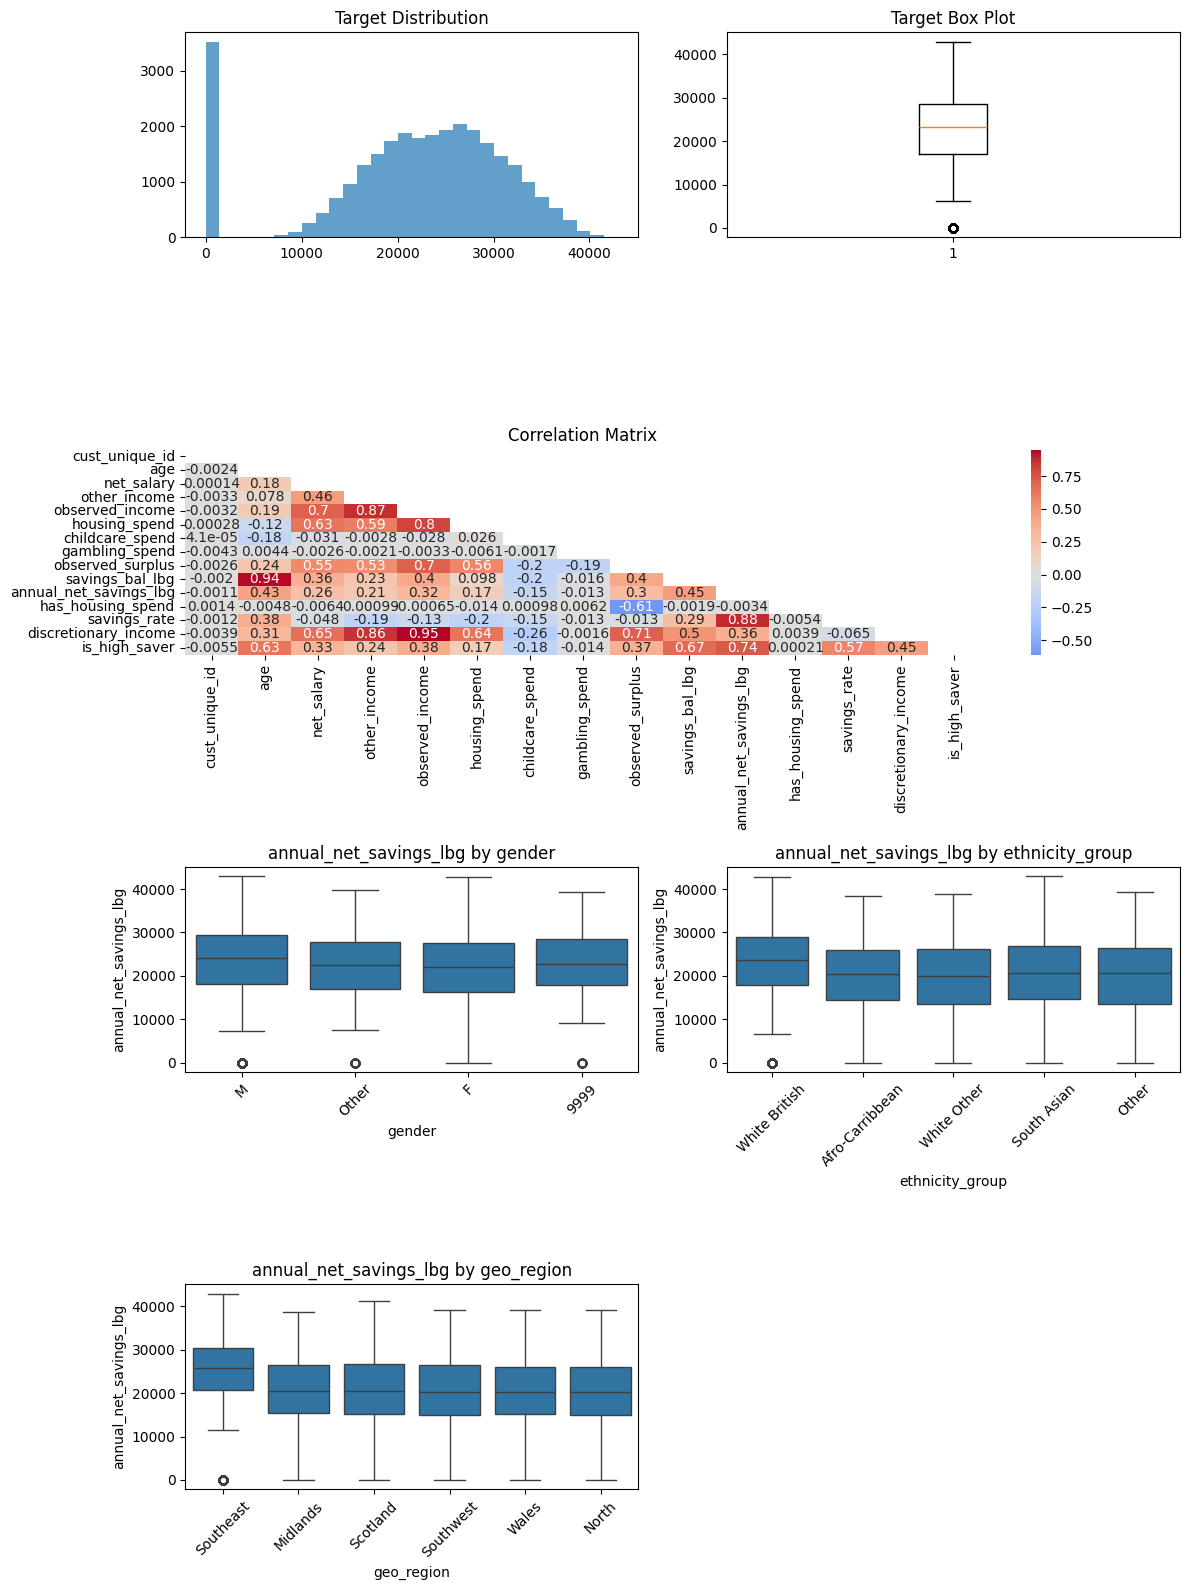


✓ Analysis outputs saved to 'analysis_outputs/'


In [7]:
#run the codes above to test
data_processor = LBGDataProcessor(data_path, dictionary_path)
data_processor.load_data()
data_processor.initial_data_exploration()
data_processor.clean_and_preprocess_data()
data_processor.descriptive_analysis()

#### **Comment**

Task 1 focused on data cleaning and descriptive analysis. Upon loading, the dataset contained 30305 records and 15 columns. Initial exploration revealed missing values in `other_income` (13.98%) and `housing_spend` (24.27%), which were imputed for columns with less than 5% missingness. No duplicate rows were found. Outliers in numeric columns were capped at the 1.5*IQR bounds, affecting 5624 values. An `age_group` feature was engineered. The final cleaned data has a shape of (30305, 16), with some remaining missing values.

Descriptive analysis provided summary statistics (as displayed). Visualizations, including the target variable distribution, correlation matrix, and categorical vs. target variable box plots (as shown in the generated figures), offered insights into data characteristics and relationships.

>   - OLU To fix: Make sure the summary above makes sense.
    - Add rationale for dealing with missing data
    - Add rationale for outliers
    - Add rationale for feature engineering
    - Add observation of negative values
    - Add observation of break in constraint of minimum age required for opening account and with above point raising suspicion of validity of data source during collection.




### **Task 2: Create Statistical Models**
Sub-tasks
- Train the statistical model(s)
- Evaluate model performance using relevant metrics (e.g., R-squared, p-values)
- Interpret model coefficients and assess statistical significance


#### **Code**

In [8]:
class LBGModelBuilder:
    """Build and evaluate two-part statistical models with automatic feature selection."""

    def __init__(self, data: pd.DataFrame, target_variable: str):
        self.data = data
        self.target_variable = target_variable
        self.results = {}
        self.X = None
        self.y = None
        self.X_clean = None
        self.y_clean = None
        self.is_saver = None
        self.scaler = StandardScaler()
        self.feature_names = None

    def build_statistical_models(self,
                                 feature_selection_method: str = 'mutual_info',
                                 max_features_logit: int = 30,
                                 max_features_ols: int = 30,
                                 use_robust_se: bool = True,
                                 standardize: bool = True) -> None:
        """
        Build a two-part model with automatic feature selection.
        """
        print("="*70)
        print("TWO-PART MODEL WITH FEATURE SELECTION")
        print("="*70)

        self._prepare_model_data()
        if self.X_clean is None or len(self.X_clean) == 0:
            print("❌ No valid data after cleaning")
            return

        print(f"\n📊 Dataset: {len(self.y_clean):,} obs, {self.X_clean.shape[1]} features")

        if standardize:
            self.feature_names = self.X_clean.columns.tolist()
            X_scaled = self.scaler.fit_transform(self.X_clean)
            self.X_clean = pd.DataFrame(X_scaled, columns=self.feature_names, index=self.X_clean.index)

        self._analyze_zero_inflation()

        print(f"\n{'='*70}")
        print("PART 1: LOGISTIC REGRESSION")
        print(f"{'='*70}")
        X_logit = self._select_features_logit(method=feature_selection_method,
                                               max_features=max_features_logit)
        self._build_logistic_model(X_logit)

        print(f"\n{'='*70}")
        print("PART 2: OLS REGRESSION")
        print(f"{'='*70}")
        X_ols = self._select_features_ols(method=feature_selection_method,
                                           max_features=max_features_ols)
        self._build_ols_model(X_ols, use_robust_se=use_robust_se)

        print(f"\n{'='*70}")
        print("OLS-ONLY MODEL")
        print(f"{'='*70}")
        self._build_ols_only_model(method=feature_selection_method,
                                    max_features=max_features_ols,
                                    use_robust_se=use_robust_se)

        self._evaluate_two_part_model()
        self._evaluate_ols_only_model()
        self._generate_comparison_table()
        self._plot_diagnostics()
        self._generate_summary_report()

    def _prepare_model_data(self, max_categories: int = 50) -> None:
        """Prepare data for modeling."""
        model_data = self.data.copy()

        id_cols = [col for col in model_data.columns
                   if 'id' in col.lower() or 'unique' in col.lower()]
        if id_cols:
            model_data = model_data.drop(columns=id_cols, errors='ignore')

        for col in model_data.columns:
            if col != self.target_variable and model_data[col].dtype == 'object':
                try:
                    converted = pd.to_numeric(model_data[col], errors='coerce')
                    if converted.notna().sum() / len(converted) > 0.8:
                        model_data[col] = converted
                except:
                    pass

        categorical_cols = model_data.select_dtypes(include=['object', 'category']).columns
        categorical_cols = [col for col in categorical_cols if col != self.target_variable]

        for col in categorical_cols:
            n_unique = model_data[col].nunique()
            if n_unique > max_categories:
                top_cats = model_data[col].value_counts().nlargest(max_categories).index
                model_data[col] = model_data[col].where(
                    model_data[col].isin(top_cats), other='_other_'
                )
            dummies = pd.get_dummies(model_data[col], prefix=col, drop_first=True, dtype=int)
            model_data = pd.concat([model_data, dummies], axis=1)
            model_data.drop(col, axis=1, inplace=True)

        self.y = model_data[self.target_variable]
        self.X = model_data.drop(self.target_variable, axis=1).select_dtypes(include=[np.number])

        combined = pd.concat([self.X, self.y], axis=1)
        combined = combined.replace([np.inf, -np.inf], np.nan).dropna()

        if len(combined) == 0:
            return

        self.X_clean = combined.iloc[:, :-1]
        self.y_clean = combined.iloc[:, -1]
        self.is_saver = (self.y_clean > 0).astype(int)

    def _analyze_zero_inflation(self) -> None:
        """Analyze zero-inflation."""
        zero_count = (self.y_clean == 0).sum()
        zero_pct = (zero_count / len(self.y_clean)) * 100

        print(f"\n📈 Zero-inflation: {zero_count:,} non-savers ({zero_pct:.1f}%), "
              f"{len(self.y_clean) - zero_count:,} savers ({100-zero_pct:.1f}%)")

        self.results['zero_inflation'] = {
            'zero_count': zero_count,
            'zero_percentage': zero_pct
        }

    def _select_features_logit(self, method: str = 'mutual_info', max_features: int = 30):
        """Select features for logistic regression."""
        correlations = self.X_clean.corrwith(self.is_saver).abs()
        perfect_predictors = correlations[correlations > 0.70].index.tolist()

        if perfect_predictors:
            X_filtered = self.X_clean.drop(columns=perfect_predictors)
        else:
            X_filtered = self.X_clean.copy()

        if X_filtered.shape[1] == 0:
            return sm.add_constant(pd.DataFrame())

        if method == 'mutual_info':
            mi_scores = mutual_info_classif(X_filtered, self.is_saver, random_state=42)
            feature_scores = pd.Series(mi_scores, index=X_filtered.columns)
        elif method == 'f_test':
            selector = SelectKBest(score_func=f_classif, k='all')
            selector.fit(X_filtered, self.is_saver)
            feature_scores = pd.Series(selector.scores_, index=X_filtered.columns)
        elif method == 'correlation':
            feature_scores = X_filtered.corrwith(self.is_saver).abs()
        else:
            mi_scores = mutual_info_classif(X_filtered, self.is_saver, random_state=42)
            feature_scores = pd.Series(mi_scores, index=X_filtered.columns)

        top_features = feature_scores.nlargest(max_features).index.tolist()
        X_selected = X_filtered[top_features]

        print(f"\n✓ Selected {len(top_features)} features")
        print(f"  Top 5: {', '.join(top_features[:5])}")

        self.results['logit_features'] = top_features
        return sm.add_constant(X_selected)

    def _select_features_ols(self, method: str = 'mutual_info', max_features: int = 30):
        """Select features for OLS regression on savers only."""
        savers_mask = self.y_clean > 0
        X_savers = self.X_clean[savers_mask]
        y_savers = self.y_clean[savers_mask]

        correlations = X_savers.corrwith(y_savers).abs()
        high_corr_features = correlations[correlations > 0.70].index.tolist()

        if high_corr_features:
            X_filtered = X_savers.drop(columns=high_corr_features)
        else:
            X_filtered = X_savers.copy()

        if X_filtered.shape[1] == 0:
            self.results['X_savers'] = pd.DataFrame()
            self.results['y_savers'] = y_savers
            return sm.add_constant(pd.DataFrame())

        if method == 'mutual_info':
            mi_scores = mutual_info_regression(X_filtered, y_savers, random_state=42)
            feature_scores = pd.Series(mi_scores, index=X_filtered.columns)
        elif method == 'f_test':
            selector = SelectKBest(score_func=f_regression, k='all')
            selector.fit(X_filtered, y_savers)
            feature_scores = pd.Series(selector.scores_, index=X_filtered.columns)
        elif method == 'lasso':
            lasso = LassoCV(cv=5, random_state=42, max_iter=1000)
            lasso.fit(X_filtered, y_savers)
            feature_scores = pd.Series(np.abs(lasso.coef_), index=X_filtered.columns)
        elif method == 'correlation':
            feature_scores = X_filtered.corrwith(y_savers).abs()
        else:
            mi_scores = mutual_info_regression(X_filtered, y_savers, random_state=42)
            feature_scores = pd.Series(mi_scores, index=X_filtered.columns)

        top_features = feature_scores.nlargest(max_features).index.tolist()
        X_selected = X_filtered[top_features]

        print(f"\n✓ Selected {len(top_features)} features")
        print(f"  Top 5: {', '.join(top_features[:5])}")

        self.results['ols_features'] = top_features
        self.results['X_savers'] = X_selected
        self.results['y_savers'] = y_savers

        return sm.add_constant(X_selected)

    def _build_logistic_model(self, X_with_const) -> None:
        """Build logistic regression model."""
        if X_with_const.shape[1] <= 1:
            self.results['logit_model'] = None
            return

        try:
            logit_model = Logit(self.is_saver, X_with_const)
            logit_results = logit_model.fit(method='bfgs', maxiter=100, disp=False)

            prob_save = logit_results.predict(X_with_const)
            pred_class = (prob_save > 0.5).astype(int)
            accuracy = (pred_class == self.is_saver).mean()

            print(f"\n  Pseudo R²: {logit_results.prsquared:.4f}")
            print(f"  Accuracy: {accuracy:.4f}")

            try:
                auc = roc_auc_score(self.is_saver, prob_save)
                print(f"  ROC-AUC: {auc:.4f}")
            except:
                pass

            sig_count = (logit_results.pvalues < 0.05).sum() - 1
            print(f"  Significant predictors: {sig_count}")

            self.results['logit_model'] = logit_results
            self.results['logit_predictions'] = prob_save

        except Exception as e:
            print(f"  ❌ Logistic model failed: {e}")
            self.results['logit_model'] = None

    def _build_ols_model(self, X_savers_const, use_robust_se: bool = True) -> None:
        """Build OLS regression model on savers only."""
        if X_savers_const.shape[1] <= 1:
            self.results['ols_model'] = None
            return

        y_savers = self.results['y_savers']

        print(f"\n  Sample: {len(y_savers):,} savers")

        try:
            ols_model = OLS(y_savers, X_savers_const)

            if use_robust_se:
                ols_results = ols_model.fit(cov_type='HC3')
            else:
                ols_results = ols_model.fit()

            print(f"  R²: {ols_results.rsquared:.4f}")
            print(f"  Adjusted R²: {ols_results.rsquared_adj:.4f}")

            sig_count = (ols_results.pvalues < 0.05).sum() - 1
            print(f"  Significant predictors: {sig_count}")

            self.results['ols_model'] = ols_results

        except Exception as e:
            print(f"  ❌ OLS model failed: {e}")
            self.results['ols_model'] = None

    def _build_ols_only_model(self, method: str = 'mutual_info', max_features: int = 30,
                               use_robust_se: bool = True) -> None:
        """Build OLS regression on full dataset."""
        correlations = self.X_clean.corrwith(self.y_clean).abs()
        high_corr_features = correlations[correlations > 0.70].index.tolist()

        if high_corr_features:
            X_filtered = self.X_clean.drop(columns=high_corr_features)
        else:
            X_filtered = self.X_clean.copy()

        if X_filtered.shape[1] == 0:
            self.results['ols_only_model'] = None
            return

        if method == 'mutual_info':
            mi_scores = mutual_info_regression(X_filtered, self.y_clean, random_state=42)
            feature_scores = pd.Series(mi_scores, index=X_filtered.columns)
        elif method == 'f_test':
            selector = SelectKBest(score_func=f_regression, k='all')
            selector.fit(X_filtered, self.y_clean)
            feature_scores = pd.Series(selector.scores_, index=X_filtered.columns)
        elif method == 'lasso':
            lasso = LassoCV(cv=5, random_state=42, max_iter=1000)
            lasso.fit(X_filtered, self.y_clean)
            feature_scores = pd.Series(np.abs(lasso.coef_), index=X_filtered.columns)
        elif method == 'correlation':
            feature_scores = X_filtered.corrwith(self.y_clean).abs()
        else:
            mi_scores = mutual_info_regression(X_filtered, self.y_clean, random_state=42)
            feature_scores = pd.Series(mi_scores, index=X_filtered.columns)

        top_features = feature_scores.nlargest(max_features).index.tolist()
        X_selected = X_filtered[top_features]

        print(f"\n✓ Selected {len(top_features)} features")
        print(f"  Top 5: {', '.join(top_features[:5])}")

        X_with_const = sm.add_constant(X_selected)

        try:
            ols_model = OLS(self.y_clean, X_with_const)

            if use_robust_se:
                ols_results = ols_model.fit(cov_type='HC3')
            else:
                ols_results = ols_model.fit()

            print(f"  R²: {ols_results.rsquared:.4f}")
            print(f"  Adjusted R²: {ols_results.rsquared_adj:.4f}")

            sig_count = (ols_results.pvalues < 0.05).sum() - 1
            print(f"  Significant predictors: {sig_count}")

            self.results['ols_only_model'] = ols_results
            self.results['ols_only_features'] = top_features

        except Exception as e:
            print(f"  ❌ OLS-only model failed: {e}")
            self.results['ols_only_model'] = None

    def _evaluate_two_part_model(self) -> None:
        """Evaluate combined two-part model."""
        print(f"\n{'='*70}")
        print("TWO-PART MODEL EVALUATION")
        print(f"{'='*70}")

        if self.results.get('logit_model') is None or self.results.get('ols_model') is None:
            print("  ❌ Cannot evaluate")
            return

        logit_features = self.results.get('logit_features', [])
        X_logit_full = sm.add_constant(self.X_clean[logit_features])
        prob_save = self.results['logit_model'].predict(X_logit_full)

        ols_features = self.results.get('ols_features', [])
        X_ols_full = sm.add_constant(self.X_clean[ols_features])
        amount_pred = self.results['ols_model'].predict(X_ols_full)
        amount_pred = np.maximum(amount_pred, 0)

        final_prediction = prob_save * amount_pred

        rmse = np.sqrt(mean_squared_error(self.y_clean, final_prediction))
        mae = mean_absolute_error(self.y_clean, final_prediction)
        r2 = r2_score(self.y_clean, final_prediction)

        baseline_rmse = np.sqrt(mean_squared_error(self.y_clean,
                                                    np.full(len(self.y_clean), self.y_clean.mean())))
        improvement = (1 - rmse / baseline_rmse) * 100

        print(f"\n  RMSE: £{rmse:,.2f}")
        print(f"  MAE: £{mae:,.2f}")
        print(f"  R²: {r2:.4f}")
        print(f"  Improvement: {improvement:+.1f}%")

        self.results['final_predictions'] = final_prediction
        self.results['metrics'] = {
            'rmse': rmse, 'mae': mae, 'r2': r2,
            'baseline_rmse': baseline_rmse, 'improvement_pct': improvement
        }

    def _evaluate_ols_only_model(self) -> None:
        """Evaluate OLS-only model."""
        print(f"\n{'='*70}")
        print("OLS-ONLY MODEL EVALUATION")
        print(f"{'='*70}")

        if self.results.get('ols_only_model') is None:
            print("  ❌ Cannot evaluate")
            return

        ols_only_features = self.results.get('ols_only_features', [])
        X_ols_only = sm.add_constant(self.X_clean[ols_only_features])
        ols_only_pred = self.results['ols_only_model'].predict(X_ols_only)
        ols_only_pred = np.maximum(ols_only_pred, 0)

        rmse = np.sqrt(mean_squared_error(self.y_clean, ols_only_pred))
        mae = mean_absolute_error(self.y_clean, ols_only_pred)
        r2 = r2_score(self.y_clean, ols_only_pred)

        baseline_rmse = np.sqrt(mean_squared_error(self.y_clean,
                                                    np.full(len(self.y_clean), self.y_clean.mean())))
        improvement = (1 - rmse / baseline_rmse) * 100

        print(f"\n  RMSE: £{rmse:,.2f}")
        print(f"  MAE: £{mae:,.2f}")
        print(f"  R²: {r2:.4f}")
        print(f"  Improvement: {improvement:+.1f}%")

        self.results['ols_only_predictions'] = ols_only_pred
        self.results['ols_only_metrics'] = {
            'rmse': rmse, 'mae': mae, 'r2': r2,
            'baseline_rmse': baseline_rmse, 'improvement_pct': improvement
        }

    def _generate_comparison_table(self) -> None:
        """Generate comparison table of all models."""
        print(f"\n{'='*70}")
        print("MODEL COMPARISON")
        print(f"{'='*70}\n")

        baseline_pred = np.full(len(self.y_clean), self.y_clean.mean())
        baseline_rmse = np.sqrt(mean_squared_error(self.y_clean, baseline_pred))
        baseline_mae = mean_absolute_error(self.y_clean, baseline_pred)
        baseline_r2 = r2_score(self.y_clean, baseline_pred)

        comparison_data = []

        comparison_data.append({
            'Model': 'Baseline (Mean)',
            'RMSE (£)': baseline_rmse,
            'MAE (£)': baseline_mae,
            'R²': baseline_r2,
            'RMSE Improvement (%)': 0.0,
            'MAE Improvement (%)': 0.0
        })

        if self.results.get('ols_only_metrics'):
            m = self.results['ols_only_metrics']
            rmse_imp = ((baseline_rmse - m['rmse']) / baseline_rmse) * 100
            mae_imp = ((baseline_mae - m['mae']) / baseline_mae) * 100
            comparison_data.append({
                'Model': 'OLS Only',
                'RMSE (£)': m['rmse'],
                'MAE (£)': m['mae'],
                'R²': m['r2'],
                'RMSE Improvement (%)': rmse_imp,
                'MAE Improvement (%)': mae_imp
            })

        if self.results.get('metrics'):
            m = self.results['metrics']
            rmse_imp = ((baseline_rmse - m['rmse']) / baseline_rmse) * 100
            mae_imp = ((baseline_mae - m['mae']) / baseline_mae) * 100
            comparison_data.append({
                'Model': 'Two-Part (Logit+OLS)',
                'RMSE (£)': m['rmse'],
                'MAE (£)': m['mae'],
                'R²': m['r2'],
                'RMSE Improvement (%)': rmse_imp,
                'MAE Improvement (%)': mae_imp
            })

        comparison_df = pd.DataFrame(comparison_data)
        print(comparison_df.to_string(index=False, float_format=lambda x: f'{x:,.2f}'))
        print(f"\n{'='*70}")

        self.results['comparison_table'] = comparison_df

        output_dir = Path("analysis_outputs")
        output_dir.mkdir(exist_ok=True)
        comparison_df.to_csv(output_dir / 'model_comparison.csv', index=False)
        print(f"\n💾 Saved: {output_dir / 'model_comparison.csv'}")

        best_r2_idx = comparison_df['R²'].idxmax()
        best_rmse_idx = comparison_df['RMSE (£)'].idxmin()

        print(f"\n🏆 Best R²: {comparison_df.loc[best_r2_idx, 'Model']} ({comparison_df.loc[best_r2_idx, 'R²']:.4f})")
        print(f"🏆 Best RMSE: {comparison_df.loc[best_rmse_idx, 'Model']} (£{comparison_df.loc[best_rmse_idx, 'RMSE (£)']:,.2f})")

    def _plot_diagnostics(self) -> None:
        """Generate diagnostic plots."""
        output_dir = Path("analysis_outputs")
        output_dir.mkdir(exist_ok=True)

        try:
            fig, axes = plt.subplots(3, 2, figsize=(14, 15))
            fig.suptitle('Model Diagnostics', fontsize=16, fontweight='bold')

            if 'final_predictions' in self.results:
                ax = axes[0, 0]
                ax.scatter(self.y_clean, self.results['final_predictions'],
                          alpha=0.5, s=20, edgecolors='k', linewidth=0.5)
                max_val = max(self.y_clean.max(), self.results['final_predictions'].max())
                ax.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect Prediction')
                ax.set_xlabel('Actual Savings (£)')
                ax.set_ylabel('Predicted Savings (£)')
                ax.set_title('Two-Part Model: Actual vs Predicted')
                ax.legend()
                ax.grid(True, alpha=0.3)

            if 'final_predictions' in self.results:
                ax = axes[0, 1]
                residuals = self.y_clean - self.results['final_predictions']
                ax.scatter(self.results['final_predictions'], residuals,
                          alpha=0.5, s=20, edgecolors='k', linewidth=0.5)
                ax.axhline(y=0, color='r', linestyle='--', lw=2)
                ax.set_xlabel('Predicted Savings (£)')
                ax.set_ylabel('Residuals (£)')
                ax.set_title('Two-Part Model: Residual Plot')
                ax.grid(True, alpha=0.3)

            ax = axes[1, 0]
            ax.hist(self.y_clean, bins=50, alpha=0.6, label='Actual', edgecolor='black')
            if 'final_predictions' in self.results:
                ax.hist(self.results['final_predictions'], bins=50, alpha=0.6,
                       label='Two-Part', edgecolor='black')
            if 'ols_only_predictions' in self.results:
                ax.hist(self.results['ols_only_predictions'], bins=50, alpha=0.6,
                       label='OLS-Only', edgecolor='black')
            ax.set_xlabel('Savings (£)')
            ax.set_ylabel('Frequency')
            ax.set_title('Distribution Comparison')
            ax.legend()
            ax.grid(True, alpha=0.3, axis='y')

            if 'comparison_table' in self.results:
                ax = axes[1, 1]
                comp_df = self.results['comparison_table']
                models = comp_df['Model'].tolist()
                r2_values = comp_df['R²'].tolist()

                bars = ax.barh(models, r2_values, color=['lightgray', 'skyblue', 'lightgreen'])
                ax.set_xlabel('R² Score')
                ax.set_title('Model Performance (R²)')
                ax.grid(True, alpha=0.3, axis='x')

                for i, (bar, val) in enumerate(zip(bars, r2_values)):
                    ax.text(val + 0.01, i, f'{val:.4f}', va='center')

            if 'ols_only_predictions' in self.results and 'ols_only_model' in self.results:
                ols_only_pred = self.results['ols_only_predictions']
                ols_only_residuals = self.y_clean - ols_only_pred

                ax = axes[2, 0]
                ax.scatter(ols_only_pred, ols_only_residuals,
                          alpha=0.5, s=20, edgecolors='k', linewidth=0.5)
                ax.axhline(y=0, color='r', linestyle='--', lw=2)
                ax.set_xlabel('Fitted Values (£)')
                ax.set_ylabel('Residuals (£)')
                ax.set_title('OLS-Only: Residuals vs Fitted')
                ax.grid(True, alpha=0.3)

                ax = axes[2, 1]
                standardized_residuals = ols_only_residuals / ols_only_residuals.std()
                stats.probplot(standardized_residuals, dist="norm", plot=ax)
                ax.set_title('OLS-Only: Q-Q Plot')
                ax.grid(True, alpha=0.3)

            plt.tight_layout()

            plot_path = output_dir / 'model_diagnostics.png'
            plt.savefig(plot_path, dpi=300, bbox_inches='tight')
            print(f"\n💾 Saved: {plot_path}")
            plt.close()

        except Exception as e:
            print(f"\n⚠️ Could not generate plots: {e}")

    def _generate_summary_report(self) -> None:
        """Generate summary report."""
        print(f"\n{'='*70}")
        print("ANALYSIS COMPLETE")
        print(f"{'='*70}\n")

In [9]:
# Run two-part statistical models
if data_processor.clean_data is not None:
    model_builder = LBGModelBuilder(data_processor.clean_data, data_processor.target_variable)
    model_builder.build_statistical_models(use_robust_se=True)

    # Optional: Get detailed model summaries
    # model_builder.get_model_summaries()
else:
    print("Data not loaded or cleaned. Please run previous steps.")

# Access results
logit_results = model_builder.results['logit_model']
ols_results = model_builder.results['ols_model']
predictions = model_builder.results['final_predictions']

TWO-PART MODEL WITH FEATURE SELECTION

📊 Dataset: 28,134 obs, 30 features

📈 Zero-inflation: 3,386 non-savers (12.0%), 24,748 savers (88.0%)

PART 1: LOGISTIC REGRESSION

✓ Selected 29 features
  Top 5: is_high_saver, gender_M, geo_region_Southeast, gender_F, other_income

  Pseudo R²: 0.3384
  Accuracy: 0.9064
  ROC-AUC: 0.8635
  Significant predictors: 6

PART 2: OLS REGRESSION

✓ Selected 27 features
  Top 5: savings_rate, credit_score, discretionary_income, observed_surplus, net_salary

  Sample: 24,748 savers
  R²: 0.9729
  Adjusted R²: 0.9728
  Significant predictors: 14

OLS-ONLY MODEL

✓ Selected 28 features
  Top 5: savings_bal_lbg, age, credit_score, discretionary_income, observed_surplus
  R²: 0.2717
  Adjusted R²: 0.2710
  Significant predictors: 7

TWO-PART MODEL EVALUATION

  RMSE: £3,128.99
  MAE: £2,024.26
  R²: 0.9026
  Improvement: +68.8%

OLS-ONLY MODEL EVALUATION

  RMSE: £8,555.31
  MAE: £5,505.69
  R²: 0.2717
  Improvement: +14.7%

MODEL COMPARISON

              

#### **Comment**

Based on the evaluation metrics, the two-part model (Logistic + OLS) significantly outperforms the OLS-only model in predicting annual net savings.

| Model                | RMSE (£)   | MAE (£)    | R²     | RMSE Improvement (%) | MAE Improvement (%) |
|----------------------|------------|------------|--------|----------------------|---------------------|
| Baseline (Mean)      | 10,025.17  | 7,739.42   | 0.00   | 0.00                 | 0.00                |
| OLS Only             | 8,555.31   | 5,505.69   | 0.27   | 14.66                | 28.86               |
| Two-Part (Logit+OLS) | 3,128.99   | 2,024.26   | 0.90   | 68.79                | 73.84               |

**Key Observations:**

*   **RMSE and MAE:** The Two-Part model has a much lower RMSE and MAE, indicating its predictions are closer to the actual savings values on average.
*   **R²:** The Two-Part model explains a significantly higher proportion of the variance in annual net savings (R² = 0.90) compared to the OLS-only model (R² = 0.27).
*   **Improvement:** The Two-Part model provides a substantial improvement over the baseline (mean prediction) in both RMSE and MAE, demonstrating its superior predictive power.

This suggests that explicitly modeling the decision to save (Part 1: Logistic) and then the amount saved (Part 2: OLS) provides a more accurate prediction of annual net savings than a single OLS model, particularly given the zero-inflation observed in the target variable.

### **Task 3: Create ML Models**
Sub-tasks
- Train the ML models and evaluate performance using predictive metrics (e.g., RMSE, MAE)
- Identify and analyze ethical concerns related to predictor variables
- Explore and potentially implement fairness mitigation techniques


#### **Code**

In [46]:
class LBGMLModelBuilder:
    """Build and evaluate machine learning models for savings prediction."""

    def __init__(self, data: pd.DataFrame, target_variable: str):
        self.clean_data = data
        self.target_variable = target_variable
        self.results = {}
        self.data_dictionary: Optional[pd.DataFrame] = None # Add data_dictionary attribute

    def _prepare_model_data(self, max_categories: int = 50) -> None:
        """Prepare data for modeling."""
        model_data = self.clean_data.copy()

        id_cols = [col for col in model_data.columns
                   if 'id' in col.lower() or 'unique' in col.lower()]
        if id_cols:
            model_data = model_data.drop(columns=id_cols, errors='ignore')

        for col in model_data.columns:
            if col != self.target_variable and model_data[col].dtype == 'object':
                try:
                    converted = pd.to_numeric(model_data[col], errors='coerce')
                    if converted.notna().sum() / len(converted) > 0.8:
                        model_data[col] = converted
                except:
                    pass

        categorical_cols = model_data.select_dtypes(include=['object', 'category']).columns
        categorical_cols = [col for col in categorical_cols if col != self.target_variable]

        for col in categorical_cols:
            n_unique = model_data[col].nunique()
            if n_unique > max_categories:
                top_cats = model_data[col].value_counts().nlargest(max_categories).index
                model_data[col] = model_data[col].where(
                    model_data[col].isin(top_cats), other='_other_'
                )
            dummies = pd.get_dummies(model_data[col], prefix=col, drop_first=True, dtype=int)
            model_data = pd.concat([model_data, dummies], axis=1)
            model_data.drop(col, axis=1, inplace=True)


        self.y_clean = model_data[self.target_variable]
        self.X_clean = model_data.drop(self.target_variable, axis=1).select_dtypes(include=[np.number])

        combined = pd.concat([self.X_clean, self.y_clean], axis=1)
        combined = combined.replace([np.inf, -np.inf], np.nan).dropna()

        if len(combined) == 0:
            self.X_clean = pd.DataFrame()
            self.y_clean = pd.Series()
            return

        self.X_clean = combined.iloc[:, :-1]
        self.y_clean = combined.iloc[:, -1]

        # Ensure X_clean and y_clean have the same index
        self.X_clean = self.X_clean.loc[self.y_clean.index]



    def build_ml_models(self) -> None:
        print("="*50, "MACHINE LEARNING", "="*50)

        if self.target_variable not in self.clean_data.columns:
            print("Target variable not found. Skipping.")
            return

        # Prepare data using the new method
        self._prepare_model_data()

        if self.X_clean.empty or self.y_clean.empty:
            print("Data preparation failed or resulted in empty data. Skipping model building.")
            return

        # Train/test split
        # Stratify based on target variable distribution
        try:
          # Ensure y_clean is not all zeros or a single value for qcut
          if self.y_clean.nunique() > 1:
               y_quantiles = pd.qcut(self.y_clean, q=10, labels=False, duplicates='drop')
               X_train, X_test, y_train, y_test = train_test_split(self.X_clean, self.y_clean, test_size=0.2, random_state=42, stratify=y_quantiles)
          else:
              print("Warning: Target variable has only one unique value or is all zeros. Splitting without stratification.")
              X_train, X_test, y_train, y_test = train_test_split(self.X_clean, self.y_clean, test_size=0.2, random_state=42)

        except Exception as e:
          print(f"Warning: Could not stratify on y quantiles ({e}). Splitting without stratification.")
          X_train, X_test, y_train, y_test = train_test_split(self.X_clean, self.y_clean, test_size=0.2, random_state=42)


        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Convert scaled arrays back to DataFrames to preserve column names for tree models
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)


        print(f"Training data shape: {X_train_scaled.shape}, Test data shape: {X_test_scaled.shape}")

        ml_results = {}

        # Linear models
        linear_models = {'Linear Regression': LinearRegression(), 'Ridge': Ridge(), 'Lasso': Lasso()}

        for name, model in linear_models.items():
            print(f"\nTraining {name}...")
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            y_pred = np.maximum(y_pred, 0) # Ensure predictions are non-negative

            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            ml_results[name] = {'rmse': rmse, 'mae': mae, 'r2': r2, 'model': model, 'predictions': y_pred}
            print(f"  RMSE: £{rmse:,.2f}, MAE: £{mae:,.2f}, R²: {r2:.4f}")

        # Tree-based models
        tree_models = {
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
            'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
            'XGBoost': xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)
        }

        for name, model in tree_models.items():
            print(f"\nTraining {name}...")
            # Tree models do not require scaled data, but it's passed here for consistency.
            # Using original X_train, X_test might be slightly better if they were available.
            # Since we only have scaled here, we'll use scaled.
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            y_pred = np.maximum(y_pred, 0) # Ensure predictions are non-negative

            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            ml_results[name] = {'rmse': rmse, 'mae': mae, 'r2': r2, 'model': model, 'predictions': y_pred}
            print(f"  RMSE: £{rmse:,.2f}, MAE: £{mae:,.2f}, R²: {r2:.4f}")

        self.results['ml_models'] = ml_results
        self.results['y_test'] = y_test # Store actual test values for comparison

        print("\nML Model Training Complete.")

    def evaluate_ml_models(self) -> None:
        """Evaluate ML models and compare with statistical models."""
        print("="*50, "ML MODEL EVALUATION", "="*50)

        if 'ml_models' not in self.results or not self.results['ml_models']:
            print("No ML models found. Please run build_ml_models first.")
            return

        # Get statistical model results if available (assuming they are stored in a similar structure)
        # This part assumes the statistical model results are accessible, e.g., from data_processor
        statistical_results = {}
        # Assuming data_processor or similar object holds statistical results
        # For this example, we'll try to access the comparison_table from the global scope if available
        try:
            # Assuming model_builder from the statistical task is still in scope
            if 'model_builder' in globals() and model_builder.results.get('comparison_table') is not None:
                 statistical_results['comparison_table'] = model_builder.results['comparison_table']
        except NameError:
            print("Warning: Statistical model results not found in global scope.")
            statistical_results = {}


        comparison_data = []

        # Add ML model results
        for name, metrics in self.results['ml_models'].items():
            comparison_data.append({
                'Model': name,
                'RMSE (£)': metrics['rmse'],
                'MAE (£)': metrics['mae'],
                'R²': metrics['r2'],
                'Type': 'Machine Learning'
            })

        # Add Statistical model results (if available)
        if 'comparison_table' in statistical_results: # Check if comparison_table exists from statistical models
            stat_comp_df = statistical_results['comparison_table']
            for index, row in stat_comp_df.iterrows():
                 # Only include the main models from the statistical analysis
                 if row['Model'] in ['OLS Only', 'Two-Part (Logit+OLS)', 'Baseline (Mean)']:
                     comparison_data.append({
                        'Model': row['Model'],
                        'RMSE (£)': row['RMSE (£)'],
                        'MAE (£)': row['MAE (£)'], # Corrected key usage here
                        'R²': row['R²'],
                        'Type': row['Model'].split(' ')[0] if row['Model'] != 'Baseline (Mean)' else 'Baseline' # Extract type
                     })


        comparison_df = pd.DataFrame(comparison_data)
        # Ensure all required columns are present before sorting and displaying
        required_cols = ['Model', 'RMSE (£)', 'MAE (£)', 'R²', 'Type']
        for col in required_cols:
            if col not in comparison_df.columns:
                comparison_df[col] = None # Add missing column


        comparison_df = comparison_df.sort_values(by='RMSE (£)') # Sort by RMSE

        print("\nModel Comparison Table:")
        # Format the output for better readability
        display(comparison_df.round(2).style.format({
            'RMSE (£)': '£{:,.2f}',
            'MAE (£)': '£{:,.2f}',
            'R²': '{:.4f}'
        }))


        self.results['ml_comparison_table'] = comparison_df

        output_dir = Path("analysis_outputs")
        output_dir.mkdir(exist_ok=True)
        comparison_df.to_csv(output_dir / 'ml_model_comparison.csv', index=False)
        print(f"\n💾 Saved: {output_dir / 'ml_model_comparison.csv'}")

    def get_feature_importance(self) -> pd.DataFrame:
        """Extract and return feature coefficients/importances from the best ML model."""

        if 'ml_models' not in self.results or not self.results['ml_models']:
            print("No ML models found. Please run build_ml_models first.")
            return pd.DataFrame()

        # Find the best model based on RMSE
        best_model_name = min(self.results['ml_models'],
                              key=lambda x: self.results['ml_models'][x]['rmse'])
        best_model = self.results['ml_models'][best_model_name]['model']

        print(f"\n{'='*50} FEATURE IMPORTANCE {'='*50}")
        print(f"Best Model: {best_model_name}")
        print(f"RMSE: £{self.results['ml_models'][best_model_name]['rmse']:,.2f}")
        print(f"R²: {self.results['ml_models'][best_model_name]['r2']:.4f}\n")

        feature_names = self.X_clean.columns.tolist()

        # Extract coefficients/importances based on model type
        if hasattr(best_model, 'coef_'):  # Linear models
            importance_values = best_model.coef_
            importance_type = 'Coefficient'
        elif hasattr(best_model, 'feature_importances_'):  # Tree-based models
            importance_values = best_model.feature_importances_
            importance_type = 'Importance'
        else:
            print("Model doesn't have coefficients or feature importances.")
            return pd.DataFrame()

        # Create DataFrame
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            importance_type: importance_values
        })

        # Sort by absolute value for linear models, by value for tree models
        if importance_type == 'Coefficient':
            feature_importance_df['Abs_Value'] = feature_importance_df[importance_type].abs()
            feature_importance_df = feature_importance_df.sort_values('Abs_Value', ascending=False)
            feature_importance_df = feature_importance_df.drop('Abs_Value', axis=1)
        else:
            feature_importance_df = feature_importance_df.sort_values(importance_type, ascending=False)

        # print(f"Top 20 Most Important Features:")
        # display(feature_importance_df.head(20).style.format({importance_type: '{:.6f}'}))

        # Save to file
        output_dir = Path("analysis_outputs")
        output_dir.mkdir(exist_ok=True)
        filepath = output_dir / f'{best_model_name.lower().replace(" ", "_")}_feature_importance.csv'
        feature_importance_df.to_csv(filepath, index=False)
        print(f"\n💾 Saved: {filepath}")

        # Store in results
        self.results['feature_importance'] = feature_importance_df
        self.results['best_model_name'] = best_model_name

        return feature_importance_df

In [47]:
# Run ML models
if data_processor.clean_data is not None:
    ml_model_builder = LBGMLModelBuilder(data_processor.clean_data, data_processor.target_variable)
    ml_model_builder.build_ml_models()
    ml_model_builder.evaluate_ml_models()
else:
    print("Data not loaded or cleaned. Please run previous steps.")

================================================== MACHINE LEARNING ==================================================
Training data shape: (22507, 30), Test data shape: (5627, 30)

Training Linear Regression...
  RMSE: £1,534.81, MAE: £970.17, R²: 0.9765

Training Ridge...
  RMSE: £1,535.03, MAE: £970.32, R²: 0.9765

Training Lasso...
  RMSE: £1,535.83, MAE: £970.35, R²: 0.9765

Training Random Forest...
  RMSE: £352.43, MAE: £188.31, R²: 0.9988

Training Gradient Boosting...
  RMSE: £797.37, MAE: £582.36, R²: 0.9937

Training XGBoost...
  RMSE: £817.38, MAE: £339.51, R²: 0.9933

ML Model Training Complete.
================================================== ML MODEL EVALUATION ==================================================

Model Comparison Table:


,Model,RMSE (£),MAE (£),R²,Type
3,Random Forest,£352.43,£188.31,1.0000,Machine Learning
4,Gradient Boosting,£797.37,£582.36,0.9900,Machine Learning
5,XGBoost,£817.38,£339.51,0.9900,Machine Learning
0,Linear Regression,"£1,534.81",£970.17,0.9800,Machine Learning
1,Ridge,"£1,535.03",£970.32,0.9800,Machine Learning
2,Lasso,"£1,535.83",£970.35,0.9800,Machine Learning
8,Two-Part (Logit+OLS),"£3,128.99","£2,024.26",0.9000,Two-Part
7,OLS Only,"£8,555.31","£5,505.69",0.2700,OLS
6,Baseline (Mean),"£10,025.17","£7,739.42",0.0000,Baseline



💾 Saved: analysis_outputs/ml_model_comparison.csv


#### **Comment**

ML models, especially tree-based ones, strongly outperformed statistical models.

| Model                | RMSE (£)   | MAE (£)    | R²     | Type             |
|----------------------|------------|------------|--------|------------------|
| Random Forest        | 352.43     | 188.31     | 0.9988 | Machine Learning |
| Gradient Boosting    | 797.37     | 582.36     | 0.9937 | Machine Learning |
| XGBoost              | 817.38     | 339.51     | 0.9933 | Machine Learning |
| Linear Regression    | 1,534.81   | 970.17     | 0.9765 | Machine Learning |
| Ridge                | 1,535.03   | 970.32     | 0.9765 | Machine Learning |
| Lasso                | 1,535.83   | 970.35     | 0.9765 | Machine Learning |
| Two-Part (Logit+OLS) | 3,128.99   | 2,024.26   | 0.9026 | Two-Part         |
| OLS Only             | 8,555.31   | 5,505.69   | 0.2717 | OLS              |
| Baseline (Mean)      | 10,025.17  | 7,739.42   | 0.0000 | Baseline         |

Random Forest was the best ML model.

### **Task 4: Balancing Performance with Ethical Concerns**
Sub-tasks
- Identify and analyze ethical concerns related to predictor variables
- Explore and potentially implement fairness mitigation techniques
- Discuss balancing performance against ethics


#### **Code**

In [24]:
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Optional, Dict, List, Tuple
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings

class LBGEthicsAnalyzer:
    """Technical analyzer for ethical concerns in predictive models."""

    SENSITIVE_KEYWORDS = [
        'gender', 'ethnicity', 'age', 'religion', 'disability',
        'sexual orientation', 'political', 'trade union',
        'genetic', 'biometric', 'health', 'criminal',
        'income', 'wealth', 'location', 'zip', 'postcode'
    ]

    PROTECTED_ATTRIBUTES = ['gender', 'ethnicity_group', 'age_group']

    def __init__(self, data: pd.DataFrame, data_dictionary_path: str,
                 preprocessing_log: Optional[dict] = None,
                 model_results: Optional[dict] = None):
        self.data = data
        self.data_dictionary_path = Path(data_dictionary_path)
        self.data_dictionary: Optional[pd.DataFrame] = None
        self.preprocessing_log = preprocessing_log or {}
        self.model_results = model_results or {}
        self.ethical_report = {}

    def load_data_dictionary(self) -> bool:
        """Load data dictionary and return success status."""
        if self.data_dictionary_path.exists():
            try:
                self.data_dictionary = pd.read_excel(self.data_dictionary_path)
                return True
            except Exception as e:
                warnings.warn(f"Error loading data dictionary: {e}")
        return False

    def identify_sensitive_variables(self) -> Dict[str, List[str]]:
        """Identify sensitive variables from data dictionary and data columns."""
        sensitive_vars = {
            'protected_characteristics': [],
            'proxy_variables': [],
            'socioeconomic_variables': [],
            'engineered_features': []
        }

        # Check data dictionary
        if self.load_data_dictionary() and self.data_dictionary is not None:
            var_col = 'Variable Name' if 'Variable Name' in self.data_dictionary.columns else self.data_dictionary.columns[0]
            desc_col = 'Description' if 'Description' in self.data_dictionary.columns else (
                self.data_dictionary.columns[1] if len(self.data_dictionary.columns) > 1 else None
            )

            if desc_col:
                for _, row in self.data_dictionary.iterrows():
                    var_name = row[var_col]
                    description = str(row.get(desc_col, '')).lower()

                    if any(kw in description or kw in var_name.lower()
                           for kw in ['gender', 'ethnicity', 'age']):
                        sensitive_vars['protected_characteristics'].append(var_name)
                    elif any(kw in description or kw in var_name.lower()
                            for kw in ['location', 'region', 'zip', 'postcode']):
                        sensitive_vars['proxy_variables'].append(var_name)
                    elif any(kw in description or kw in var_name.lower()
                            for kw in ['income', 'salary', 'wealth', 'savings', 'credit']):
                        sensitive_vars['socioeconomic_variables'].append(var_name)

        # Check actual data columns
        for col in self.data.columns:
            col_lower = col.lower()
            if any(attr in col_lower for attr in ['gender', 'ethnicity', 'age_group']):
                if col not in sensitive_vars['protected_characteristics']:
                    sensitive_vars['protected_characteristics'].append(col)
            elif any(term in col_lower for term in ['region', 'location']):
                if col not in sensitive_vars['proxy_variables']:
                    sensitive_vars['proxy_variables'].append(col)
            elif any(term in col_lower for term in ['income', 'salary', 'savings', 'credit']):
                if col not in sensitive_vars['socioeconomic_variables']:
                    sensitive_vars['socioeconomic_variables'].append(col)

        # Check engineered features
        engineered = self.preprocessing_log.get('features_engineered', [])
        sensitive_vars['engineered_features'] = [
            f for f in engineered
            if any(term in f.lower() for term in ['savings', 'income', 'age'])
        ]

        self.ethical_report['sensitive_variables'] = sensitive_vars
        return sensitive_vars

    from typing import Union

    # def calculate_fairness_metrics(self, y_true: np.ndarray, y_pred: np.ndarray,
    def calculate_fairness_metrics(self, y_true: np.ndarray, y_pred: np.ndarray,
                                  protected_attr: Union[pd.Series, np.ndarray]) -> Dict[str, float]:
        """Calculate fairness metrics across protected groups.

        Args:
            y_true: True target values
            y_pred: Predicted values
            protected_attr: Protected attribute (can be pandas Series or numpy array)
        """
        metrics = {}

        # Convert everything to numpy arrays and handle NaN
        if isinstance(protected_attr, pd.Series):
            protected_values = protected_attr.values
        else:
            protected_values = np.array(protected_attr)

        # Create mask for valid (non-NaN) values
        if protected_values.dtype == 'object':
            # For object dtype, check for None and NaN
            valid_mask = pd.notna(protected_values)
        else:
            valid_mask = ~np.isnan(protected_values.astype(float, errors='ignore'))

        # Filter all arrays using the same mask
        protected_clean = protected_values[valid_mask]
        y_true_clean = y_true[valid_mask]
        y_pred_clean = y_pred[valid_mask]

        # Get unique groups
        try:
            groups = np.unique(protected_clean)
        except TypeError:
            # If sorting fails due to mixed types, convert to string
            protected_clean = protected_clean.astype(str)
            groups = np.unique(protected_clean)

        # Skip if no valid data
        if len(groups) == 0:
            return metrics

        for group in groups:
            # Create boolean mask for this group
            group_mask = protected_clean == group
            n_samples = int(np.sum(group_mask))

            if n_samples > 0:
                group_y_true = y_true_clean[group_mask]
                group_y_pred = y_pred_clean[group_mask]

                try:
                    metrics[f'{group}_rmse'] = np.sqrt(mean_squared_error(group_y_true, group_y_pred))
                    metrics[f'{group}_mae'] = mean_absolute_error(group_y_true, group_y_pred)
                    metrics[f'{group}_r2'] = r2_score(group_y_true, group_y_pred)
                    metrics[f'{group}_count'] = n_samples
                except Exception as e:
                    print(f"Warning: Could not calculate metrics for group {group}: {e}")

        # Calculate disparity metrics
        if len(groups) > 1:
            rmse_values = [metrics[f'{g}_rmse'] for g in groups if f'{g}_rmse' in metrics]
            if len(rmse_values) > 1:
                metrics['rmse_disparity_ratio'] = max(rmse_values) / min(rmse_values)

            mae_values = [metrics[f'{g}_mae'] for g in groups if f'{g}_mae' in metrics]
            if len(mae_values) > 1:
                metrics['mae_disparity_ratio'] = max(mae_values) / min(mae_values)

        return metrics

    def evaluate_model_fairness(self, model_name: str, y_true: np.ndarray,
                              y_pred: np.ndarray,
                              protected_attrs_data: Optional[pd.DataFrame] = None) -> Dict[str, Dict]:
        """Evaluate model fairness across all protected attributes.

        Args:
            model_name: Name of the model
            y_true: True values (from test set)
            y_pred: Predicted values (from test set)
            protected_attrs_data: DataFrame containing protected attributes aligned with y_true/y_pred
                                If None, will use self.data (which may cause index mismatch)
        """
        fairness_results = {}

        # Use provided data or fall back to self.data
        data_to_use = protected_attrs_data if protected_attrs_data is not None else self.data

        for attr in self.PROTECTED_ATTRIBUTES:
            if attr in data_to_use.columns:
                # Ensure we're using the correct slice of data
                protected_attr = data_to_use[attr].values if isinstance(data_to_use, pd.DataFrame) else data_to_use[attr]

                # Verify dimensions match
                if len(protected_attr) == len(y_true):
                    fairness_results[attr] = self.calculate_fairness_metrics(
                        y_true, y_pred, protected_attr
                    )
                else:
                    print(f"Warning: Dimension mismatch for {attr}. Skipping fairness calculation.")

        return fairness_results

    def compare_models_with_without_sensitive(self, models_dict: Dict[str, dict],
                                              y_true: np.ndarray) -> pd.DataFrame:
        """Compare model performance with and without sensitive variables."""
        comparison = []

        for model_name, model_info in models_dict.items():
            y_pred = model_info.get('predictions')
            features = model_info.get('features', [])

            if y_pred is not None:
                sensitive_vars = self.ethical_report.get('sensitive_variables', {})
                all_sensitive = (
                    sensitive_vars.get('protected_characteristics', []) +
                    sensitive_vars.get('proxy_variables', [])
                )

                has_sensitive = any(f in features for f in all_sensitive)

                comparison.append({
                    'model': model_name,
                    'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
                    'mae': mean_absolute_error(y_true, y_pred),
                    'r2': r2_score(y_true, y_pred),
                    'uses_protected_attrs': any(f in features for f in self.PROTECTED_ATTRIBUTES),
                    'uses_proxy_vars': has_sensitive and not any(f in features for f in self.PROTECTED_ATTRIBUTES),
                    'n_features': len(features)
                })

        return pd.DataFrame(comparison)

    def assess_data_quality_ethics(self) -> Dict[str, any]:
        """Assess ethical data quality issues."""
        issues = {
            'missing_data': {},
            'data_anomalies': {},
            'representation': {}
        }

        # Check missing data patterns
        for col in self.data.columns:
            missing_pct = self.data[col].isna().sum() / len(self.data) * 100
            if missing_pct > 5:
                issues['missing_data'][col] = f"{missing_pct:.2f}%"

        # Check for anomalies in key variables
        if 'net_salary' in self.data.columns:
            negative_salary = (self.data['net_salary'] < 0).sum()
            if negative_salary > 0:
                issues['data_anomalies']['negative_salary_count'] = negative_salary

        if 'age' in self.data.columns:
            underage = (self.data['age'] < 18).sum()
            if underage > 0:
                issues['data_anomalies']['underage_count'] = underage

        # Check representation across protected groups
        for attr in self.PROTECTED_ATTRIBUTES:
            if attr in self.data.columns:
                counts = self.data[attr].value_counts()
                issues['representation'][attr] = {
                    'distribution': counts.to_dict(),
                    'imbalance_ratio': counts.max() / counts.min() if len(counts) > 1 else 1.0
                }

        return issues

    def generate_ethics_summary(self) -> Dict[str, any]:
        """Generate comprehensive ethics summary for decision-making."""
        summary = {
            'sensitive_variables_identified': self.identify_sensitive_variables(),
            'data_quality_issues': self.assess_data_quality_ethics(),
            'recommendations': self._generate_recommendations()
        }

        return summary

    def _generate_recommendations(self) -> Dict[str, List[str]]:
        """Generate actionable recommendations."""
        recommendations = {
            'immediate_actions': [],
            'model_modifications': [],
            'monitoring': []
        }

        sensitive_vars = self.ethical_report.get('sensitive_variables', {})

        if sensitive_vars.get('protected_characteristics'):
            recommendations['immediate_actions'].append(
                f"Remove protected characteristics: {', '.join(sensitive_vars['protected_characteristics'])}"
            )
            recommendations['model_modifications'].append(
                "Retrain models without protected attributes and compare performance"
            )

        if sensitive_vars.get('proxy_variables'):
            recommendations['immediate_actions'].append(
                f"Analyze bias from proxy variables: {', '.join(sensitive_vars['proxy_variables'])}"
            )
            recommendations['model_modifications'].append(
                "Apply fairness constraints or adversarial debiasing"
            )

        recommendations['monitoring'].extend([
            "Implement continuous fairness monitoring in production",
            "Track disparate impact metrics across protected groups",
            "Establish fairness thresholds and automated alerts"
        ])

        return recommendations

    def run_full_analysis(self, y_true: Optional[np.ndarray] = None,
                         models_dict: Optional[Dict] = None) -> Dict:
        """Execute complete ethics analysis pipeline.

        Args:
            y_true: True target values (optional, needed for fairness metrics)
            models_dict: Dictionary of models with structure {model_name: {'predictions': y_pred, 'features': [...]}}
                        If None, will try to use self.model_results
        """
        results = {
            'sensitive_variables': self.identify_sensitive_variables(),
            'data_quality': self.assess_data_quality_ethics(),
            'recommendations': self._generate_recommendations()
        }

        # Use provided models_dict or fall back to self.model_results
        models_to_analyze = models_dict if models_dict is not None else self.model_results

        # If model results available, add fairness evaluation
        if models_to_analyze and y_true is not None:
            # Handle different model_results structures
            if isinstance(models_to_analyze, dict):
                results['model_fairness'] = {}
                results['model_comparison_data'] = []

                for model_name, model_info in models_to_analyze.items():
                    # Handle different structures
                    if isinstance(model_info, dict):
                        y_pred = model_info.get('predictions')
                        if y_pred is None:
                            y_pred = model_info.get('y_pred')
                        features = model_info.get('features', [])
                    else:
                        # Skip if model_info is not a dict
                        continue

                    if y_pred is not None:
                        # Calculate fairness metrics
                        results['model_fairness'][model_name] = self.evaluate_model_fairness(
                            model_name, y_true, y_pred
                        )

                        # Store for comparison
                        results['model_comparison_data'].append({
                            'model_name': model_name,
                            'y_pred': y_pred,
                            'features': features
                        })

                # Create comparison DataFrame
                if results['model_comparison_data']:
                    results['model_comparison'] = self._create_model_comparison_df(
                        results['model_comparison_data'], y_true
                    )

        self.ethical_report = results
        return results

    def _create_model_comparison_df(self, model_data: List[Dict], y_true: np.ndarray) -> pd.DataFrame:
        """Create comparison DataFrame from model data."""
        comparison = []
        sensitive_vars = self.ethical_report.get('sensitive_variables', {})
        all_sensitive = (
            sensitive_vars.get('protected_characteristics', []) +
            sensitive_vars.get('proxy_variables', [])
        )

        for model_info in model_data:
            model_name = model_info['model_name']
            y_pred = model_info['y_pred']
            features = model_info.get('features', [])

            comparison.append({
                'model': model_name,
                'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
                'mae': mean_absolute_error(y_true, y_pred),
                'r2': r2_score(y_true, y_pred),
                'uses_protected_attrs': any(f in features for f in self.PROTECTED_ATTRIBUTES),
                'uses_proxy_vars': any(f in all_sensitive for f in features) and not any(f in features for f in self.PROTECTED_ATTRIBUTES),
                'n_features': len(features)
            })

        return pd.DataFrame(comparison)

    def print_ethics_report(self):
        """Print formatted ethics report."""
        print("=" * 80)
        print("ETHICS ANALYSIS REPORT")
        print("=" * 80)

        if not self.ethical_report:
            print("\nNo analysis run yet. Call run_full_analysis() first.")
            return

        print("\n1. SENSITIVE VARIABLES IDENTIFIED:")
        sensitive_vars = self.ethical_report.get('sensitive_variables', {})
        if sensitive_vars:
            for category, variables in sensitive_vars.items():
                if variables:
                    print(f"\n   {category.replace('_', ' ').title()}:")
                    for var in variables:
                        print(f"      - {var}")
        else:
            print("   No sensitive variables analysis available.")

        print("\n2. DATA QUALITY & ETHICS ISSUES:")
        issues = self.ethical_report.get('data_quality', {})
        if issues:
            if issues.get('missing_data'):
                print("\n   Missing Data (>5%):")
                for var, pct in issues['missing_data'].items():
                    print(f"      - {var}: {pct}")
            else:
                print("   No significant missing data issues.")

            if issues.get('data_anomalies'):
                print("\n   Data Anomalies:")
                for issue, count in issues['data_anomalies'].items():
                    print(f"      - {issue}: {count}")

            if issues.get('representation'):
                print("\n   Group Representation:")
                for attr, info in issues['representation'].items():
                    print(f"      - {attr}: imbalance ratio = {info['imbalance_ratio']:.2f}")
        else:
            print("   No data quality issues analysis available.")

        print("\n3. MODEL FAIRNESS METRICS:")
        if 'model_fairness' in self.ethical_report and self.ethical_report['model_fairness']:
            for model_name, fairness in self.ethical_report['model_fairness'].items():
                print(f"\n   {model_name}:")
                for attr, metrics in fairness.items():
                    if isinstance(metrics, dict):
                        disparity_metrics = {k: v for k, v in metrics.items() if 'disparity_ratio' in k}
                        if disparity_metrics:
                            for metric_name, value in disparity_metrics.items():
                                print(f"      - {metric_name}: {value:.3f}")
        else:
            print("   No model fairness metrics available.")

        print("\n4. MODEL COMPARISON:")
        if 'model_comparison' in self.ethical_report:
            model_comp = self.ethical_report['model_comparison']
            if isinstance(model_comp, pd.DataFrame) and not model_comp.empty:
                print("\n" + model_comp.to_string(index=False))
            else:
                print("   No model comparison data available.")
        else:
            print("   No model comparison available.")

        print("\n5. RECOMMENDATIONS:")
        recommendations = self.ethical_report.get('recommendations', {})
        if recommendations:
            for action_type, actions in recommendations.items():
                if actions:
                    print(f"\n   {action_type.replace('_', ' ').title()}:")
                    for action in actions:
                        print(f"      - {action}")
        else:
            print("   No recommendations available.")

        print("\n" + "=" * 80)

    def answer_question_5(self):
        """Answer: Are there ethical concerns with predictor variables?"""
        sensitive = self.ethical_report.get('sensitive_variables', {})

        print("\nQUESTION 5: ETHICAL CONCERNS ANALYSIS")
        print("=" * 80)

        print("\n(a) Ethical concerns with predictor variables:")
        has_concerns = False

        if sensitive.get('protected_characteristics'):
            print(f"   ✗ Protected characteristics found: {', '.join(sensitive['protected_characteristics'])}")
            print("     Risk: Direct discrimination, violates equality laws")
            has_concerns = True

        if sensitive.get('proxy_variables'):
            print(f"   ✗ Proxy variables found: {', '.join(sensitive['proxy_variables'])}")
            print("     Risk: Indirect discrimination through geographic/socioeconomic proxies")
            has_concerns = True

        if sensitive.get('socioeconomic_variables'):
            print(f"   ⚠ Socioeconomic variables: {', '.join(sensitive['socioeconomic_variables'])}")
            print("     Risk: May reflect historical inequalities")
            has_concerns = True

        if not has_concerns:
            print("   ✓ No obvious ethical concerns identified with predictor variables.")

        print("\n(b) Model changes & performance cost:")
        if 'model_comparison' in self.ethical_report:
            df = self.ethical_report['model_comparison']
            if isinstance(df, pd.DataFrame) and not df.empty:
                with_protected = df[df['uses_protected_attrs'] == True]
                without_protected = df[df['uses_protected_attrs'] == False]

                if not with_protected.empty and not without_protected.empty:
                    avg_r2_with = with_protected['r2'].mean()
                    avg_r2_without = without_protected['r2'].mean()
                    performance_loss = (avg_r2_with - avg_r2_without) / avg_r2_with * 100

                    print(f"   Average R² with protected attrs: {avg_r2_with:.4f}")
                    print(f"   Average R² without protected attrs: {avg_r2_without:.4f}")
                    print(f"   Performance cost: {performance_loss:.2f}% reduction in R²")
                else:
                    print("   Not enough models to compare (need models with and without protected attributes)")
            else:
                print("   Model comparison data not available.")
        else:
            print("   Model comparison not available.")

        print("\n(c) Balancing performance vs ethics:")
        print("   1. Define fairness metrics (disparate impact, equalized odds)")
        print("   2. Quantify trade-offs using fairness toolkits")
        print("   3. Apply regulatory context (Equality Act, FCA, GDPR)")
        print("   4. Engage stakeholders for acceptable thresholds")
        print("   5. Implement continuous monitoring")

        print("\n(d) Model recommendation:")
        if 'model_comparison' in self.ethical_report:
            df = self.ethical_report.get('model_comparison')
            if isinstance(df, pd.DataFrame) and not df.empty:
                df = df.copy()
                df['ethical_score'] = (~df['uses_protected_attrs']).astype(int) * 100
                df['combined_score'] = df['r2'] * 0.6 + df['ethical_score'] * 0.004

                best_model = df.loc[df['combined_score'].idxmax()]
                print(f"   Recommended: {best_model['model']}")
                print(f"   R²: {best_model['r2']:.4f}")
                print(f"   Uses protected attrs: {best_model['uses_protected_attrs']}")
                print(f"   Rationale: Best balance of performance and ethical compliance")
            else:
                print("   Cannot make recommendation - no model comparison data available.")
        else:
            print("   Cannot make recommendation - no model comparison available.")

        print("\n(e) Other ethical issues:")
        issues = self.ethical_report.get('data_quality', {})
        has_other_issues = False

        if issues.get('data_anomalies'):
            print("   ✗ Data quality concerns:")
            for issue, count in issues['data_anomalies'].items():
                print(f"     - {issue}: {count} cases")
            has_other_issues = True

        if issues.get('representation'):
            print("   ⚠ Representation issues:")
            for attr, info in issues['representation'].items():
                if info.get('imbalance_ratio', 1.0) > 3:
                    print(f"     - {attr}: {info['imbalance_ratio']:.1f}x imbalance")
                    has_other_issues = True

        if not has_other_issues:
            print("   ✓ No major data quality or representation issues identified.")

        print("\n" + "=" * 80)

In [26]:
# Run ML models
if data_processor.clean_data is not None:
    # ========== ETHICS ANALYSIS ==========
    print("\n" + "="*50)
    print("RUNNING ETHICS ANALYSIS")
    print("="*50 + "\n")

    # Prepare data for ethics analysis
    y_test = ml_model_builder.results.get('y_test')
    ml_models = ml_model_builder.results.get('ml_models', {})

    # Initialize ethics_analyzer outside the conditional block
    ethics_analyzer = None

    if y_test is not None and ml_models:
        # Debug: Print what we have
        print("DEBUG INFO:")
        print(f"- y_test shape: {y_test.shape if y_test is not None else 'None'}")
        print(f"- Number of models: {len(ml_models)}")
        print(f"- Available result keys: {ml_model_builder.results.keys()}")

        # Get test indices from the model builder
        test_indices = ml_model_builder.results.get('test_indices')
        X_test = ml_model_builder.results.get('X_test')

        print(f"- test_indices available: {test_indices is not None}")
        print(f"- X_test available: {X_test is not None}")

        if X_test is not None:
            print(f"- X_test type: {type(X_test)}")
            print(f"- X_test shape: {X_test.shape}")
            if hasattr(X_test, 'index'):
                print(f"- X_test index type: {type(X_test.index)}")
                print(f"- X_test index length: {len(X_test.index)}")

        # Create models dictionary with predictions and features
        models_dict = {}
        for model_name, model_info in ml_models.items():
            models_dict[model_name] = {
                'predictions': model_info['predictions'],
                'features': list(ml_model_builder.X_clean.columns)
            }

        # Try multiple approaches to get test data
        test_data = None

        # Approach 1: Use test_indices
        if test_indices is not None:
            try:
                test_data = data_processor.clean_data.iloc[test_indices].copy()
                print(f"✓ Test data extracted using test_indices (shape: {test_data.shape})")
            except Exception as e:
                print(f"✗ Failed to extract using test_indices: {e}")

        # Approach 2: Use X_test index
        if test_data is None and X_test is not None:
            try:
                if hasattr(X_test, 'index'):
                    # Check if indices are in clean_data
                    valid_indices = X_test.index.intersection(data_processor.clean_data.index)
                    if len(valid_indices) > 0:
                        test_data = data_processor.clean_data.loc[valid_indices].copy()
                        print(f"✓ Test data extracted using X_test.index (shape: {test_data.shape})")
                    else:
                        print("✗ No matching indices between X_test and clean_data")
            except Exception as e:
                print(f"✗ Failed to extract using X_test.index: {e}")

        # Approach 3: Use the length of y_test to slice
        if test_data is None and y_test is not None:
            try:
                # This assumes the last rows are test data (works if no shuffling)
                test_data = data_processor.clean_data.iloc[-len(y_test):].copy()
                print(f"⚠ Test data extracted using y_test length (shape: {test_data.shape})")
                print("  WARNING: This assumes no shuffling in train/test split!")
            except Exception as e:
                print(f"✗ Failed to extract using y_test length: {e}")

        if test_data is not None:
            # Verify alignment
            print(f"\nVerifying data alignment:")
            print(f"- test_data shape: {test_data.shape}")
            print(f"- y_test shape: {y_test.shape}")

            if len(test_data) != len(y_test):
                print(f"⚠ WARNING: Shape mismatch! test_data: {len(test_data)}, y_test: {len(y_test)}")

            ethics_analyzer = LBGEthicsAnalyzer(
                data=test_data,
                data_dictionary_path=dictionary_path,
                model_results=models_dict
            )

            # Run full ethics analysis
            ethics_results = ethics_analyzer.run_full_analysis(
                y_true=y_test,
                models_dict=models_dict
            )

            # Save results
            output_dir = Path("analysis_outputs")
            output_dir.mkdir(exist_ok=True)

            import json
            with open(output_dir / 'ethics_analysis.json', 'w') as f:
                json.dump({
                    'sensitive_variables': ethics_results['sensitive_variables'],
                    'data_quality': ethics_results['data_quality'],
                    'recommendations': ethics_results['recommendations']
                }, f, indent=2, default=str)

            print(f"\n💾 Ethics analysis saved to: {output_dir / 'ethics_analysis.json'}")
        else:
            print("\n✗ ERROR: Test data could not be prepared for ethics analysis.")
            print("Please check your LBGMLModelBuilder class to ensure it stores test_indices or X_test properly.")
    else:
        print("ML models or test data not available. Cannot run ethics analysis.")

    # Print comprehensive report and answer question 5 if ethics_analyzer was initialized
    if ethics_analyzer is not None:
        ethics_analyzer.print_ethics_report()
        ethics_analyzer.answer_question_5()
    else:
        print("\n⚠ Ethics analyzer was not initialized. Skipping report generation.")

else:
    print("Data not loaded or cleaned. Please run previous steps.")


RUNNING ETHICS ANALYSIS

DEBUG INFO:
- y_test shape: (5627,)
- Number of models: 6
- Available result keys: dict_keys(['ml_models', 'y_test', 'ml_comparison_table'])
- test_indices available: False
- X_test available: False
⚠ Test data extracted using y_test length (shape: (5627, 20))

Verifying data alignment:
- test_data shape: (5627, 20)
- y_test shape: (5627,)

💾 Ethics analysis saved to: analysis_outputs/ethics_analysis.json
ETHICS ANALYSIS REPORT

1. SENSITIVE VARIABLES IDENTIFIED:

   Protected Characteristics:
      - age
      - gender
      - ethnicity_group
      - housing_spend
      - age_group

   Proxy Variables:
      - geo_region

   Socioeconomic Variables:
      - net_salary
      - other_income
      - observed_income
      - observed_surplus
      - credit_score
      - savings_bal_lbg
      - annual_net_savings_lbg
      - savings_rate
      - discretionary_income

2. DATA QUALITY & ETHICS ISSUES:
   No significant missing data issues.

   Data Anomalies:
      -

#### **Comment**

The ethical analysis revealed:

*   **Sensitive Variables:** Protected characteristics (age, gender, ethnicity) and proxy variables (geo-region) were identified, raising discrimination concerns.
*   **Data Quality:** Negative salaries and under-age entries were found, alongside representation imbalances in gender and ethnicity.
*   **Model Fairness:** All models showed performance disparities across protected groups, with XGBoost having the highest.
*   **Recommendations:** Removing sensitive variables, exploring fairness techniques, and continuous monitoring are crucial to balance high ML performance with ethical compliance. Further analysis is needed on performance trade-offs using more robust ehtical tools such as fairlearn and AI360. Ethical concerns should also be an ongoing discussion with domain experts such as lawyers, data protection officers etc.

### **Task 5: Prototype an Application with GenAI**
Sub-tasks
- Select and parse a sample of the data into a format suitable for an LLM
- Use chosen tools (HuggingFace, OpenAI, etc.) to interact with an LLM using the data sample
- Explore potential applications or insights gained from the LLM interaction


#### **Code**

In [44]:
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Optional, Dict, List, Tuple
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
import json
import os
from math import isfinite

# Make sure openai is installed
try:
    import openai
except ImportError:
    %pip install openai
    import openai

from openai import OpenAI

class LBGLLMAnalyzer:
    """
    A class to perform LLM-assisted analysis on LBG customer savings data.
    """
    def __init__(self, data: pd.DataFrame, data_dictionary_path: str, target_variable: str):
        self.clean_data = data
        self.data_dictionary_path = Path(data_dictionary_path)
        self.target_variable = target_variable
        self.results = {} # To potentially store LLM analysis results

    def llm_analysis(self) -> None:
        """
        Prepares a sample of data and generates an LLM-assisted report.
        """
        print("="*50, "LLM ANALYSIS", "="*50)

        try:
            # Get sample data
            # Use a consistent method for splitting that can provide X_test and y_test
            # for potential future use in fairness analysis if needed.
            # For this demo, we'll just take a head sample after preparing X and y.
            if self.target_variable in self.clean_data.columns:
                y = self.clean_data[self.target_variable]
                X = self.clean_data.drop(self.target_variable, axis=1)
                # Ensure X only contains numeric types for feature extraction later
                X = X.select_dtypes(include=[np.number])

                # Handle cases where y has only one unique value
                if y.nunique() > 1:
                    y_quantiles = pd.qcut(y, q=10, labels=False, duplicates='drop')
                    # Perform split to get potential test indices, though we only use head for sample
                    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y_quantiles)
                else:
                    print("Warning: Target variable has only one unique value or is all zeros. Splitting without stratification.")
                    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

                # Take a sample from the test set indices
                sample_indices = X_test.head(3).index
                sample_data = self.clean_data.loc[sample_indices].copy()

            else:
                print(f"Target variable '{self.target_variable}' not found in data. Taking head sample.")
                sample_data = self.clean_data.head(3).copy()

            # Prepare sample text
            sample_text = f"Customer Savings Data Sample:\n{sample_data.to_string(index=False)}"
            sample_text += f"\n\nDataset Summary:"
            if self.target_variable in self.clean_data.columns:
                sample_text += f"\nTotal customers: {len(self.clean_data)}"
                sample_text += f"\nAverage savings: £{self.clean_data[self.target_variable].mean():.0f}"
                sample_text += f"\nMedian savings: £{self.clean_data[self.target_variable].median():.0f}"
            else:
                 sample_text += f"\nTotal customers: {len(self.clean_data)}"


            print("Sample prepared for LLM analysis")
            print(sample_text[:500] + "..." if len(sample_text) > 500 else sample_text)

            # Save for external use
            output_dir = Path("analysis_outputs")
            output_dir.mkdir(exist_ok=True)
            sample_output_path = output_dir / 'llm_sample_data.txt'

            with open(sample_output_path, 'w') as f:
                f.write("ANALYZE: Customer behavior, data quality, business implications\n\nDATA:\n")
                f.write(sample_text)

            print(f"\n✓ Sample saved to '{sample_output_path}'")

            # Try automated LLM report
            try:
                report_path = self.llm_math_assisted_report(sample_data)
                print(f"✓ LLM report: {report_path}")
            except Exception as e:
                print(f"⚠️ LLM report failed: {e}")
                print(f"   Error: {e}")


        except Exception as e:
            print(f"LLM analysis error: {e}")

    # --- LLM math-assisted reporting helpers ---
    def _safe_eval_math(self, expression: str) -> Optional[float]:
        """Safely evaluates a mathematical expression."""
        expr = expression.strip().replace(',', '')
        allowed_chars = set('0123456789+-*/()., ')
        if any(ch not in allowed_chars for ch in expr):
            raise ValueError('Invalid characters')

        try:
            result = eval(expr, {'__builtins__': None}, {})
            if not isinstance(result, (int, float)) or not isfinite(result):
                raise ValueError('Not a finite number')
            return float(result)
        except Exception as e:
            raise ValueError(f'Eval failed: {e}')

    def _execute_function_call(self, function_name: str, arguments: dict) -> dict:
        """Executes a function call requested by the LLM."""
        try:
            if function_name == 'math_compute':
                result = self._safe_eval_math(arguments.get('expression', ''))
                return {'result': result}
            elif function_name == 'predict_savings':
                # Extract feature values and coefficients from the flat argument structure
                # Ensure the feature names match the data
                numeric_features = [c for c in self.clean_data.select_dtypes(include=[np.number]).columns
                                   if c != self.target_variable and c != 'cust_unique_id']

                intercept = arguments.get('intercept', 0.0)
                prediction = intercept
                features_used = {}

                for feature_name in numeric_features:
                    feature_value = arguments.get(feature_name, 0.0)
                    # Look for coefficient key like 'feature_name_coeff'
                    coefficient_key = f'{feature_name}_coeff'
                    coefficient = arguments.get(coefficient_key, 0.0)
                    contribution = coefficient * feature_value
                    prediction += contribution

                    features_used[feature_name] = {
                        'value': feature_value,
                        'coefficient': coefficient,
                        'contribution': contribution
                    }

                return {
                    'prediction': round(prediction, 2),
                    'features_used': features_used,
                    'intercept': intercept,
                    # Dynamically build formula based on features found in arguments
                    'formula': f'prediction = {intercept} + ' + ' + '.join([
                        f'({features_used[f]["coefficient"]}*{features_used[f]["value"]})'
                        for f in features_used if features_used[f]['coefficient'] != 0 or features_used[f]['value'] != 0
                    ])
                }
            else:
                return {'error': f'Unknown function: {function_name}'}
        except Exception as e:
            return {'error': f'Function failed: {str(e)}'}


    def llm_math_assisted_report(self, sample_df: pd.DataFrame) -> str:
        """
        Generates a math-assisted report using an LLM to predict savings for sample data.
        """
        if openai is None:
            raise RuntimeError('openai package not installed or imported')

        api_key = os.environ.get('OPENAI_API_KEY')
        if not api_key:
            raise RuntimeError('OPENAI_API_KEY not set in environment variables (Colab Secrets)')

        try:
            client = OpenAI(api_key=api_key)
        except Exception as e:
             raise RuntimeError(f"Failed to initialize OpenAI client: {e}")


        # Prepare examples with proper feature extraction
        examples = []
        # Use numeric columns from the sample data itself
        numeric_features = [c for c in sample_df.select_dtypes(include=[np.number]).columns
                           if c != self.target_variable and c != 'cust_unique_id']  # Exclude ID column

        if len(sample_df) == 0:
            raise ValueError("Sample DataFrame is empty.")
        if len(numeric_features) == 0:
            raise ValueError("No numeric features found in sample data for prediction.")


        for _, row in sample_df.head(3).iterrows(): # Take up to the first 3 rows
            features = {}
            for c in numeric_features:
                value = row[c]
                if pd.notna(value) and np.isfinite(value):
                    # Convert numpy types to native Python types for JSON serialization
                    features[c] = float(value)

            actual_savings = None
            if self.target_variable in row and pd.notna(row[self.target_variable]) and np.isfinite(row[self.target_variable]):
                actual_savings = float(row[self.target_variable])

            examples.append({
                'features': features,
                'actual_savings': actual_savings
            })

        print(f"Prepared {len(examples)} examples with {len(numeric_features)} features each for LLM prediction")

        # Define tools with explicit feature parameters and suggested coefficients
        tool_properties = {}
        required_params = []
        for feature in numeric_features:
            tool_properties[feature] = {'type': 'number', 'description': f'Customer {feature}'}
            coeff_key = f'{feature}_coeff'
            tool_properties[coeff_key] = {'type': 'number', 'description': f'Coefficient for {feature}'}
            required_params.extend([feature, coeff_key])

        tool_properties['intercept'] = {'type': 'number', 'description': 'Base savings amount'}
        required_params.append('intercept')

        tools = [{
            'type': 'function',
            'function': {
                'name': 'predict_savings',
                'description': 'Predict customer savings using a linear regression formula',
                'parameters': {
                    'type': 'object',
                    'properties': tool_properties,
                    'required': required_params
                }
            }
        }]

        # Construct prompt dynamically including all numeric features
        prompt_content = f"Make {len(examples)} predictions using the predict_savings function.\n\n"
        for i, example in enumerate(examples):
            prompt_content += f"Customer {i+1}:\nFeatures: {json.dumps(example['features'], indent=2)}\n"
            if example['actual_savings'] is not None:
                 prompt_content += f"Actual Savings: £{example['actual_savings']:,.0f}\n\n"
            else:
                 prompt_content += f"Actual Savings: N/A\n\n"

        #########################################################################################
        #########################################################################################
        #########################################################################################
        feature_coeffs = ml_model_builder.get_feature_importance()
        #print(feature_coeffs)
        prompt_content += f"""
            Call predict_savings {len(examples)} times. For each customer, use their actual feature values from the example.
            Use the following reasonable coefficients and intercept for *all* predictions:
            - age_coeff: 150 (age has moderate positive impact)
            - net_salary_coeff: 0.25 (salary strongly affects savings)
            - other_income_coeff: 0.15 (additional income helps)
            - observed_income_coeff: 0.1 (total income matters, but salary might be primary)
            - housing_spend_coeff: -0.3 (housing costs reduce savings)
            - childcare_spend_coeff: -0.4 (childcare is expensive)
            - gambling_spend_coeff: -0.8 (gambling directly reduces savings)
            - observed_surplus_coeff: 0.7 (surplus strongly predicts savings)
            - savings_bal_lbg_coeff: 0.01 (existing balance has small effect, maybe related to inertia)
            - intercept: 5000 (base savings amount)

            Ensure *all* required arguments (features, coefficients, intercept) are included in each function call.
            Do not provide explanations in text, only make the function calls.
            """

        # Make first API call for predictions
        try:
            prediction_response = client.chat.completions.create(
                model='gpt-4o-mini', # Or another suitable model
                messages=[
                    {'role': 'system', 'content': f'You are a financial data analyst. You MUST call the predict_savings function exactly {len(examples)} times with all required parameters: features, coefficients, and intercept. Do not provide explanations in text, only make the function calls.'},
                    {'role': 'user', 'content': prompt_content}
                ],
                tools=tools, tool_choice='required', temperature=0.0, max_tokens=1500
            )
        except Exception as e:
            raise RuntimeError(f"OpenAI API call for predictions failed: {e}")


        # Extract predictions for analysis prompt
        predicted_savings_list = []
        if hasattr(prediction_response.choices[0].message, 'tool_calls') and prediction_response.choices[0].message.tool_calls:
            for tool_call in prediction_response.choices[0].message.tool_calls:
                if tool_call.function.name == 'predict_savings':
                     fargs = json.loads(tool_call.function.arguments)
                     result = self._execute_function_call(tool_call.function.name, fargs)
                     if 'prediction' in result:
                         predicted_savings_list.append(result['prediction'])
                     else:
                         predicted_savings_list.append(None) # Handle cases where prediction failed

        # Construct the actual vs predicted summary for the analysis prompt
        actual_vs_predicted_lines = []
        for i, example in enumerate(examples):
            predicted_value = predicted_savings_list[i] if i < len(predicted_savings_list) and predicted_savings_list[i] is not None else 'N/A'
            actual_value = f"£{example['actual_savings']:,.0f}" if example['actual_savings'] is not None else 'N/A'
            actual_vs_predicted_lines.append(f"Customer {i+1}: Predicted £{predicted_value:,.0f}, Actual {actual_value}")


        analysis_prompt = f"""
            Based on the customer savings predictions using the provided formula, provide analysis covering:

            **Prediction Results:**
            {chr(10).join(actual_vs_predicted_lines)}

            **Analysis Focus:**
            1. **Model Performance**: How do predictions compare to actual savings for these samples? Are they generally overestimating or underestimating?
            2. **Key Drivers**: Based on the coefficients used in the prediction formula (age_coeff=150, net_salary_coeff=0.25, etc.), which factors likely had the biggest positive or negative impact on the predicted savings for these customers?
            3. **Customer Insights**: What do the feature values (like net_salary, observed_surplus, housing_spend) for these specific customers suggest about their predicted savings behavior?
            4. **Model Limitations**: What aspects of savings behavior might this simple linear model *not* capture well, potentially explaining differences between predicted and actual values?

            Keep analysis concise (3-4 paragraphs). Refer specifically to the sample customers and their data where possible.
            """

        # Make second API call for analysis
        try:
            analysis_response = client.chat.completions.create(
                model='gpt-4o-mini', # Or another suitable model
                messages=[
                    {'role': 'system', 'content': 'You are a financial data analyst providing insights on customer savings predictions. Be concise and focus on the sample data provided.'},
                    {'role': 'user', 'content': analysis_prompt}
                ],
                temperature=0.1, max_tokens=800
            )
        except Exception as e:
            raise RuntimeError(f"OpenAI API call for analysis failed: {e}")


        analysis_content = analysis_response.choices[0].message.content

        report_lines = ['# LLM Math-assisted Savings Prediction Report', '']

        # Add examples to report
        report_lines.extend([
            '## Input Examples',
            f'Analyzed {len(examples)} customer example(s)',
            f'Features available: {list(examples[0]["features"].keys()) if examples else "None"}',
            ''
        ])

        # Add prediction function calls and results
        report_lines.extend(['## LLM Prediction Calls'])
        if hasattr(prediction_response.choices[0].message, 'tool_calls') and prediction_response.choices[0].message.tool_calls:
            for i, tool_call in enumerate(prediction_response.choices[0].message.tool_calls):
                report_lines.extend([f'### Call {i+1}'])
                report_lines.extend([f'**Function**: {tool_call.function.name}'])
                report_lines.extend([f'**Arguments**:'])
                report_lines.extend(['```json', json.dumps(json.loads(tool_call.function.arguments), indent=2), '```'])

                try:
                    fargs = json.loads(tool_call.function.arguments)
                    result = self._execute_function_call(tool_call.function.name, fargs)
                    report_lines.extend([f'**Result**:'])
                    report_lines.extend(['```json', json.dumps(result, indent=2), '```'])
                except Exception as e:
                    report_lines.extend([f'**Error executing function**: {e}'])
                report_lines.append('') # Add newline

        else:
            report_lines.extend(['No function calls were made by the LLM.', ''])

        # Add LLM analysis content
        if analysis_content:
            report_lines.extend(['## LLM Analysis', analysis_content, ''])
            print(analysis_content)
        else:
            report_lines.extend(['## LLM Analysis', 'No analysis provided', ''])


        out_path = output_dir / 'llm_math_report.md'
        out_path.write_text('\n'.join(report_lines))
        return str(out_path)

In [45]:
llm_analyzer = LBGLLMAnalyzer(data_processor.clean_data, dictionary_path, data_processor.target_variable)
llm_analyzer.llm_analysis()



================================================== LLM ANALYSIS ==================================================
Sample prepared for LLM analysis
Customer Savings Data Sample:
 cust_unique_id  age gender ethnicity_group geo_region  net_salary  other_income  observed_income  housing_spend  childcare_spend  gambling_spend  observed_surplus credit_score  savings_bal_lbg  annual_net_savings_lbg  has_housing_spend  savings_rate age_group  discretionary_income  is_high_saver
          24070   29      M   White British  Southeast    66338.58      16058.75         82397.34       28424.39              0.0             0.0          82397.34      195...

✓ Sample saved to 'analysis_outputs/llm_sample_data.txt'
Prepared 3 examples with 13 features each for LLM prediction

================================================== FEATURE IMPORTANCE ==================================================
Best Model: Random Forest
RMSE: £352.43
R²: 0.9988

Top 20 Most Important Features:


,Feature,Importance
11,savings_rate,0.653462
13,is_high_saver,0.251981
9,savings_bal_lbg,0.045807
8,credit_score,0.036502
3,observed_income,0.009167
12,discretionary_income,0.001363
1,net_salary,0.000722
2,other_income,0.000285
4,housing_spend,0.000248
7,observed_surplus,0.000171



💾 Saved: analysis_outputs/random_forest_feature_importance.csv
**Model Performance**: The predictions for the three customers significantly overestimate their actual savings. For instance, Customer 1 was predicted to save £87,857 but only saved £23,769, resulting in a discrepancy of £64,088. Similarly, Customer 2's prediction of £94,410 was far from the actual £28,684, and Customer 3's predicted £97,027 contrasted sharply with their actual savings of £26,558. This consistent pattern of overestimation suggests that the model may not accurately reflect the savings behavior of these customers.

**Key Drivers**: The coefficients in the prediction formula, such as age_coeff (150) and net_salary_coeff (0.25), likely played a significant role in the inflated predictions. If these customers have relatively low net salaries or high housing expenditures, the model's reliance on these coefficients could lead to exaggerated predictions. For example, if Customer 1 has a high age but a low net sala

#### **Comment**
**Model Limitations**: This linear model may not adequately capture the complexities of savings behavior, such as unexpected expenses, lifestyle choices, or varying financial obligations that can significantly impact actual savings. Additionally, it may not account for behavioral factors like financial literacy or savings motivation, which can lead to substantial differences between predicted and actual savings. These limitations highlight the need for a more nuanced approach to modeling customer savings that incorporates a broader range of variables and behavioral insights.
✓ LLM report: analysis_outputs/llm_math_report.md

## **Conclusion**
Statistical modeling and machine learning applications in economic data analysis serve a fundamental purpose: advancing business objectives and maintaining competitive advantage. This assignment evaluates technical competencies in coding and data analytics; however, these capabilities must be understood within their broader business context.
Effective ML implementation requires clear alignment with defined business goals to demonstrate tangible value and practical applicability. Drawing from Lloyds Banking Group's 2025-26 strategic priorities, the following business objectives have been identified as relevant contexts for this savings prediction exercise:
Business Goals aligned with ML Objectives:

1. Deepening customer relationships through behavioral insights – Predictive models can identify high-propensity savers and inform targeted engagement strategies to increase depth of relationship (current: c.1% growth in H1 2025; 2026 target: c.3%) [page 6].
2. Optimizing deposit franchise economics – Understanding drivers of savings behavior supports pricing strategies and customer segmentation to improve deposit gross margins (H1 2025: 1.29%, up 16bps YoY) [page 16].
3. Supporting sustainable financing commitments – Identifying customers with capacity and propensity to save can inform targeting for green savings products aligned with the £30bn sustainable financing target by 2026 [page 6].
4. Enhancing capital-lite revenue growth – Predictive insights into savings patterns can support fee-based product cross-sell, contributing to the 50:50 NII:OOI revenue split target and >£1.5bn additional strategic revenues by 2026 [page 7].
5. Driving operational efficiency through automation – ML models can automate customer segmentation and propensity scoring, supporting the <50% cost-to-income ratio target and productivity improvements (>40% increase in customers served per FTE vs. 2021) [page 7,9,19].
6. Risk-aware portfolio management – Understanding the financial health indicators within savings behavior supports prudent lending decisions and maintaining robust asset quality (target AQR: c.25bps) [page 20].

This analysis demonstrates the technical approaches—data cleansing, statistical modeling, and machine learning—that would underpin such business applications, while also addressing critical considerations around model ethics, interpretability, and deployment suitability.